In [1]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import csv
import os
from tqdm import tqdm
import pandas as pd

In [2]:
def log_results(results, filename, type_): #function to log results. We log into different csv file

    if type_ == '1k_logs': #log of every 1k steps : critic and actor loss
        headers = ['Critic loss', 'Actor loss']  

        with open(filename, 'a', newline='') as csvfile:
            writer = csv.writer(csvfile)
            
            if csvfile.tell() == 0:
                writer.writerow(headers)
            
            writer.writerow(results)

    elif type_ == '20k_ep_rewards': #for the evaluation, log the mean of the 10 episodes
        headers = ['Mean episodic reward']  # Add your result names here

        with open(filename, 'a', newline='') as csvfile:
            writer = csv.writer(csvfile)
            
            if csvfile.tell() == 0:
                writer.writerow(headers)
            
            writer.writerow(results)
    
    elif type_ == 'ep_reward': #log accumulated reward each time an episode ends along with which step it ended in
        headers = ['Episodic reward', 'Step']  

        with open(filename, 'a', newline='') as csvfile:
            writer = csv.writer(csvfile)
            
            if csvfile.tell() == 0:
                writer.writerow(headers)
            
            writer.writerow(results)


In [3]:
class Actor(nn.Module): #class for the actor network, discrete case
    def __init__(self, state_dim, n_actions):
        super().__init__()

        self.model = nn.Sequential(
            
            nn.Linear(state_dim,64), #input, first hidden
            nn.Tanh(),
            nn.Linear(64,64), #second hidden layer
            nn.Tanh(),
            nn.Linear(64,n_actions), #output
            nn.Softmax()
        )

    def forward(self, x):
        x = torch.Tensor(x)
        return self.model(x)

In [4]:
class Actor_continuous(nn.Module): #Actor newtork, continuous case

    def __init__(self, state_dim):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(state_dim, 64), #input, first hidden
            nn.Tanh(),
            nn.Linear(64,64), #second hidden layer
            nn.Tanh(),
            nn.Linear(64,1) #output : only 1, we return the mean of the normal distribution
        )
        self.log_std = nn.Parameter(torch.zeros(1)) #the log_std is a state independant parameter, initialized at zero

    def forward(self, x):
        x = torch.Tensor(x) 
        mean = self.model(x)
        log_std = self.log_std

        return mean, log_std #we return both the mean and the log of the std

In [5]:
class Critic(nn.Module): #Critic network
    def __init__(self, state_dim):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(state_dim, 64), #input, first hidden
            nn.Tanh(),
            nn.Linear(64,64), #second hidden layer
            nn.Tanh(),
            nn.Linear(64,1) #output
        )

    def forward(self,x):
        x = torch.Tensor(x)
        return self.model(x)

In [6]:
class A2C_Agent(): #Class for the A2C agent, contains methods to choose action according to policy, get the losses of the networks, update parameters   and do evaluation.

    def __init__(self, n_envs, actor, critic, lr_actor, lr_critic, continuous = False):
        self.n_envs = n_envs
        self.actor = actor #a n agent has one actor network...
        self.critic = critic #... and one critic network
        self.actor_optimizer = torch.optim.Adam(actor.parameters(), lr=lr_actor) #as well as one optimizer per networks
        self.critic_optimizer = torch.optim.Adam(critic.parameters(), lr=lr_critic)
        self.continuous = continuous #parameter to know wether we are in the continuous env
    

    def choose_action(self, states, action_type = "training"): #method to choose an action given a state

        if not self.continuous : 

            if action_type == "training": #when training we return actions, log_probs and state_values
                
                state_values = self.critic(states)#get state values
                action_probs = self.actor(states)#probs#

                actions_pd = torch.distributions.Categorical(probs=action_probs)#create a distribution to sample from
                actions = actions_pd.sample()#choose an action according to the actual policy
                actions_log_prog = actions_pd.log_prob(actions)#comput the log_probs
                
                return actions, actions_log_prog, state_values
            
            elif action_type == 'eval': #in evaluation we use greedy policy
                with torch.no_grad()  :    

                    state_values = self.critic(states)
                    action_probs = self.actor(states)

                    actions = torch.argmax(action_probs) #greedy policy
                return actions, state_values
        
        else :

            if action_type == 'training':

                state_values = self.critic(states)#get state values
                mean, log_std = self.actor(states)#get mean and log_std of the normal distribution to sample from

                normal = torch.distributions.Normal(mean, torch.exp(log_std)) #create a distribution to sample from
                actions = normal.sample()#sample an action
                actions_log_prob = normal.log_prob(actions) #get the log_prob (before clamping)

                actions_r = torch.clamp(actions, -3., 3.) #we don't forget to clamp to get an act readable by the env

                return actions_r, actions_log_prob, state_values
            
            elif action_type == 'eval':
                with torch.no_grad():
                    state_values = self.critic(states)
                    mean, log_std = self.actor(states)

                    actions = mean #in eval we are greedy so we take the most probable action : the mean
                    actions_r = torch.clamp(actions, -3., 3.)
                return actions_r, state_values
        

        
    
    def get_losses(self, rewards, v_states, v_next_states, log_probs, gamma, terminated): #This method computes the loss given collected experience.

        if terminated is not None: #terminated = None means we are in the n_steps case, where we compute the loss a bit differently.
        
            Rt = torch.Tensor(rewards.reshape(self.n_envs,1)) + (1-torch.Tensor(terminated.reshape(self.n_envs,1))) * gamma * (v_next_states).detach() #Rt is reward + gamma * V(st+1), here we bootstrap correctly adding a (1-terminated), we also detach V(st+1) since we don't need these gradients.
            advantage = Rt - v_states

            critic_loss = advantage.pow(2).mean() #take the mean since we can have n environments
            actor_loss = - (advantage.detach() * log_probs.reshape_as(advantage.detach())).mean()

            return actor_loss, critic_loss
        
        else: #used when we do n_steps. Here !!! v_next_states correspond to the discounted rewards at each steps !!!
            advantages = v_next_states.detach() - v_states

            critic_loss = (advantages.pow(2)).mean()
            actor_loss = (-(advantages.detach() * log_probs)).mean()

            return actor_loss, critic_loss
            
    
    def update_params(self, critic_loss, actor_loss): #method to update the parameters using the optimizers
        
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()
        

        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

    def evaluate_performance(self): #method to evaluate peformance of the agent every 20k steps : run it on 10 episodes of a new environment.
        
        episodic_rewards_10 = []
        v_values = []

        if self.continuous : 
            env = gym.make("InvertedPendulum-v4")
        else: 
            env = gym.make("CartPole-v1")

        for j in range(10): #we run 10 episodes
            state, _ = env.reset()
            total_reward = 0
            done = False
            while not done:
                action, state_values = self.choose_action(state, action_type= "eval") 
                
                if j == 0 : #we take v values from first episode
                    v_values.append(state_values.detach().data.numpy()) 
                
                #go to the next state
                next_state, reward, terminated, truncated, _  = env.step(action.detach().data.numpy())
                total_reward += reward
                state = next_state
                
                done = terminated or truncated
            episodic_rewards_10.append(total_reward)
        print("episodic return of the 20000:", np.mean(episodic_rewards_10)) #we print to follow
        return np.mean(episodic_rewards_10), v_values
    

In [7]:
def train(seed, filenames, n_envs=1, sparse=False, continuous=False): #function to train an agent, with 1 step boostrapping 

    v_values = []
    max_steps = 500000

    if not continuous:
        env = gym.vector.AsyncVectorEnv([lambda:gym.make("CartPole-v1") for _ in range(n_envs)])
        state_dim  = env.single_observation_space.shape[0]
        n_actions = env.single_action_space.n

        torch.manual_seed(seed)
        actor = Actor(state_dim, n_actions)
        critic = Critic(state_dim)
        agent = A2C_Agent(n_envs=n_envs, actor=actor, critic=critic, lr_actor=1e-5, lr_critic=1e-3, continuous=continuous)
    
    else : 
        env = gym.vector.AsyncVectorEnv([lambda:gym.make("InvertedPendulum-v4") for _ in range(n_envs)])
        state_dim  = env.single_observation_space.shape[0]

        torch.manual_seed(seed)
        actor = Actor_continuous(state_dim)
        critic = Critic(state_dim)
        agent = A2C_Agent(n_envs=n_envs, actor=actor, critic=critic, lr_actor=1e-5, lr_critic=1e-3, continuous=continuous)

    
    state = env.reset(seed=seed)[0] #get first state

    ep_reward = [0]*n_envs #variable to store episodic reward of each env played

    for s in tqdm(range(0, max_steps, n_envs)): #we do steps of n_envs

        ## We don't need to reset the environment since we use gym's AsyncEnv ##
        
        actions, actions_log_prog, v_state = agent.choose_action(state) 
        
        next_state, reward, terminated, truncated, info = env.step(actions.numpy())
        st1 = next_state.copy() #we create a copy of next state in order to modify it if the state is truncated, for correct bootstrapping

        for i in range(n_envs):
            ep_reward[i] += reward[i]
            if terminated[i] or truncated[i]: #if env i is terminated or truncated
                st1[i] = info['final_observation'][i] #we retrieve the terminal (terminated or truncated) state to correctly boostrap (doesn't matter for terminated since it zeroed out but it does for truncated)

                log_results([ep_reward[i], s], filenames[3], 'ep_reward') #we log the episode rewards
                ep_reward[i] = 0
        
        if sparse: #if sparse we put the reward at 0 with a probability of 90%
            reward =  np.random.binomial(1, 0.1, size=reward.shape) * reward

        v_st1 = agent.critic(st1) #we compute v_values for the next state, to compute losses
            
        actor_loss, critic_loss = agent.get_losses(reward, v_state, v_st1, actions_log_prog, 0.99, terminated) #compute losses
        state = next_state#update state to next_state (already reset in case of terminal)


        agent.update_params(critic_loss, actor_loss) #we update the parameters
        
        if (s % (round(1000/(n_envs))*n_envs)) == 0: #every 1000k steps (or closer multiple to 1000 of n_envs) we log the losses
            log_results([critic_loss.detach().data.numpy(), actor_loss.detach().data.numpy()], filenames[0], "1k_logs")
            
        if (s % (round(20000/(n_envs))*n_envs) == 0): #every 20000 steps (or multiple) we do 10 episode evaluations and retrieve v values and log rewards
            reward_20k, vs = agent.evaluate_performance()
            log_results([reward_20k], filenames[1], "20k_ep_rewards")
            vvs = []
            for v in vs:
                vvs.append(v[0])
            v_values.append(vvs)
            
                                
    col_names = ['V_Values_'+str(i) for i in range(0,500001,20000)] #at the end we log all the v values we got during evaluation into a csv file.
    series = []

    for name, v in zip(col_names, v_values): 
        serie = pd.Series(v, name=name)
        series.append(serie)
    
    df = pd.concat(series, axis=1)
    df.to_csv(filenames[2], index=False)



In [8]:
def compute_n_steps_return(gamma, rewards, v_state, terminated): #function to compute n-step discounted returns, given rewards and last state value :  R = rt + gamma*rt+1 + gamma^2*rt+2 + ... + gamma^n * V(st+n)
    r_ = 0
    r = []

    for i in reversed(range(len(rewards))):
        r_ = rewards[i] + gamma*(r_)
        r.insert(0,r_+(1-terminated)*gamma**(i+1)*v_state)

    return torch.stack(r)

In [9]:
def train_n(seed, filenames, n_envs=1, n_steps=1, sparse=False, continuous = False, lr_actor=1e-5): #function to train an agent, bootstrapping every n_steps
    v_values = []
    max_steps = 500000

    if not continuous:
        env = gym.vector.AsyncVectorEnv([lambda:gym.make("CartPole-v1") for _ in range(n_envs)])
        state_dim  = env.single_observation_space.shape[0]
        n_actions = env.single_action_space.n

        torch.manual_seed(seed)
        actor = Actor(state_dim, n_actions)
        critic = Critic(state_dim)
        agent = A2C_Agent(n_envs=n_envs, actor=actor, critic=critic, lr_actor=lr_actor, lr_critic=1e-3, continuous=continuous)
    
    else : 
        env = gym.vector.AsyncVectorEnv([lambda:gym.make("InvertedPendulum-v4") for _ in range(n_envs)])
        state_dim  = env.single_observation_space.shape[0]

        torch.manual_seed(seed)
        actor = Actor_continuous(state_dim)
        critic = Critic(state_dim)
        agent = A2C_Agent(n_envs=n_envs, actor=actor, critic=critic, lr_actor=lr_actor, lr_critic=1e-3, continuous=continuous)
    
    state = env.reset(seed=seed)[0]

    ep_reward = [0]*n_envs #variable to store episodic reward of each env played

    for s in tqdm(range(0,max_steps,n_envs*n_steps)): #we do steps of n_steps * n_envs

        ## We don't need to reset the environment since we use gym's AsyncEnv ##

        rewards_n = torch.zeros((n_steps, n_envs)) #to store rewards from the n steps
        log_probs_n = torch.zeros((n_steps, n_envs)) #to store log probs
        states_n = torch.zeros((n_steps, n_envs)) #to store state values
        discounted_n = torch.zeros((n_steps, n_envs)) #to store discounted returns

        n = 1 #to count steps, could use j below, but a bit more convenient to follow imo
        n_term = [0]*n_envs #to follow where environments terminate/truncate: bc discounted returns are computed per episodes, so we must keep track of where episode end so we don't mix up episodes.

        for j in range(n_steps): #we loop over the n steps

            actions, actions_log_prog, vp = agent.choose_action(state)
            log_probs_n[j] = actions_log_prog.reshape(1, n_envs) #log the log probs
            states_n[j] = vp.reshape(1, n_envs) #and state values
          
            next_state, reward, terminated, truncated, info = env.step(actions.numpy()) #look at next state
            st1 = next_state.copy() #create a copy in case it is terminal so we can have the right state value.

            for i in range(n_envs): 
                ep_reward[i] += reward[i] #update episode rewards for each envs

            if sparse: #we zero the reward with 90% probability
                reward =  np.random.binomial(1, 0.1, size=reward.shape) * reward

            rewards_n[j] = torch.Tensor(reward) #log the reward for the loss computation
            
            for i in range(n_envs):
                if terminated[i] or truncated[i]: #if env i is terminal
                    log_results([ep_reward[i], s], filenames[3], 'ep_reward') #we log episode reward
                    ep_reward[i] = 0

                    st1[i] = info['final_observation'][i]  #we retrieve the terminal state
                    v_st1 = agent.critic(st1[i]) #and compute its state value

                    a = compute_n_steps_return(0.99, rewards_n[n_term[i]:n,i], v_st1, terminated[i])#and we compute the discounted return
                    discounted_n[n_term[i]:n,i] = a.reshape(1,n-n_term[i]) #and log it
                    n_term[i] = n #and update where env i was terminal

        
            if j == n_steps-1: #at the end of the 6 steps, we must compute all of discounted returns
                for i in range(n_envs):
                    if not (terminated[i] or truncated[i]): #if terminal, was computed above so we skip
                        v_st1 = agent.critic(next_state[i]) #we take last state v value
                        a = compute_n_steps_return(0.99, rewards_n[n_term[i]:n,i], v_st1, terminated[i]) #compute the discounted return from last termination point to the end
                        discounted_n[n_term[i]:n,i] = a.reshape(1,n-n_term[i]) #and log it 

            state = next_state #we update the state with the next one
            n += 1

        actor_loss, critic_loss = agent.get_losses(rewards_n, states_n, discounted_n, log_probs_n, 0.99, terminated=None) #at the end of the n steps we compute the losses. Terminated is None to use the right agent's method.

        agent.update_params(critic_loss, actor_loss) #we update the params using the above losses
        
        if (s % (round(1000/(n_steps*n_envs))*n_steps*n_envs)) == 0:#every 1000k steps (or closer multiple to 1000 of n_envs) we log the losses
            log_results([critic_loss.detach().data.numpy(), actor_loss.detach().data.numpy()], filenames[0], "1k_logs")
            
        if (s % (round(20000/(n_steps*n_envs))*n_steps*n_envs) == 0): #every 20000l steps (or multiple) we do 10 evaluation episodes and log the results
            reward_20k, vs = agent.evaluate_performance()
            log_results([reward_20k], filenames[1], "20k_ep_rewards")
            vvs = []
            for v in vs:
                vvs.append(v[0])
            v_values.append(vvs)
            
                                
    col_names = ['V_Values_'+str(i) for i in range(0,520001,20000)]#at the end we log all the v values we got during evaluation into a csv file.
    series = []

    for name, v in zip(col_names, v_values): 
        serie = pd.Series(v, name=name)
        series.append(serie)
    
    df = pd.concat(series, axis=1)
    df.to_csv(filenames[2], index=False)

In [103]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
                        
def plotting(folder_name, seeds): #function to make all the plots for report
    actors  = []
    critics = []
    rewards_20 = []
    v_values = [[] for _ in range(len(seeds))]
    v0 = []
    v1 = []
    v2 = []
    all_rewards = []
    steps = []
    aggregated_seed = []
    aggregated_seed_steps = []
    colors = ['blue', 'green', 'red']
    for i, seed in enumerate(seeds):

        filenames = [os.path.join(folder_name, str(seed)+'_1_1k.csv'), os.path.join(folder_name, str(seed)+'_1_20k_rewards.csv'), 
                 os.path.join(folder_name, str(seed)+'_1_20k_V_Values.csv'), os.path.join(folder_name, str(seed)+'_1_Ep_Rewards.csv')]
        data1 = pd.read_csv(filenames[0])

        actors.append(data1['Actor loss'])
        critics.append(data1['Critic loss'])

        data2 = pd.read_csv(filenames[1])
        rewards_20.append(data2['Mean episodic reward'])

        data3 = pd.read_csv(filenames[2])

        
        v0.append(data3['V_Values_20000'])  #v_value at begining : first evaluatio
        v1.append(data3['V_Values_260000']) #in the middle
        v2.append(data3['V_Values_480000']) #at the end

        for col in data3.columns:
            v_values[i].append(data3[col].mean())

        data4 = pd.read_csv(filenames[3])
        aggregated = data4.groupby('Step', as_index=False).mean() #in case multiple envs ended at same step, we take the mean
        all_rewards.append(aggregated['Episodic reward'])
        steps.append(aggregated['Step'])

        multiples_of_1000 = list(range(1000, 501001, 1000)) #for aggregating seeds, we take the last value for each of them right before each 1k steps, and we will take the mean, min and max of the seeds
        result = []

        for mult in multiples_of_1000:
            filtered_df = aggregated[aggregated['Step'] < mult]
            if not filtered_df.empty:
                last_value = filtered_df.iloc[-1]['Episodic reward']
                result.append({'step': mult, 'value': last_value})

        result_df = pd.DataFrame(result)

        aggregated_seed.append(result_df['value'])
        aggregated_seed_steps.append(result_df['step'])

    print(v_values[0])
    mean_actors = np.mean(actors, axis=0)
    mean_critics = np.mean(critics, axis=0)
    mean_rewards20 = np.mean(rewards_20, axis=0)
    mean_vs = np.mean(v_values, axis=0)
    mean_aggr = np.mean(aggregated_seed, axis = 0)
    mean_v0 = np.nanmean(v0, axis=0)
    mean_v1 = np.nanmean(v1, axis=0)
    mean_v2 = np.nanmean(v2, axis=0)

    max_actors = np.max(actors, axis=0)
    max_critics = np.max(critics, axis=0)
    max_rewards20 = np.max(rewards_20, axis=0)
    max_aggr = np.max(aggregated_seed, axis = 0)

    min_actors = np.min(actors, axis=0)
    min_critics = np.min(critics, axis=0)
    min_rewards20 = np.min(rewards_20, axis=0)
    min_aggr = np.min(aggregated_seed, axis=0)


    plt.plot(range(len(mean_actors)), mean_actors, color='blue', marker='x', linestyle='', label='Mean')
    plt.fill_between(range(len(mean_actors)), min_actors, max_actors, color='gray', alpha=0.3, label='Min-Max Range')
    plt.yscale('log')

    plt.xlabel('Step * 1000')
    plt.ylabel('Actor loss')
    plt.legend()
    plt.savefig(os.path.join(folder_name, 'Actor.jpg'), dpi=300)

    plt.figure()
    plt.plot(range(len(mean_critics)), mean_critics, color='blue', marker='x', label='Mean')
    plt.fill_between(range(len(mean_critics)), min_critics, max_critics, color='gray', alpha=0.3, label='Min-Max Range')
    plt.yscale('log')

    plt.xlabel('Step * 1000')
    plt.ylabel('Critic loss')
    plt.legend()
    plt.savefig(os.path.join(folder_name, 'Critic.jpg'), dpi=300)


    plt.figure()
    plt.plot(range(len(mean_rewards20)), mean_rewards20, color='blue', label='Mean')
    plt.fill_between(range(len(mean_rewards20)), min_rewards20, max_rewards20, color='gray', alpha=0.3, label='Min-Max Range')

    plt.xlabel('Step * 20000')
    plt.ylabel('Mean episodic reward')
    plt.legend()
    plt.savefig(os.path.join(folder_name, 'Rewards_20k.jpg'), dpi=300)

    plt.figure()
    plt.plot(range(len(mean_vs)), mean_vs, color='blue', label='Mean')
    plt.xlabel('Step * 20000')
    plt.ylabel('Value function')
    plt.savefig(os.path.join(folder_name, 'V_Values.jpg'), dpi=300)

    for i in range(len(seeds)):
        plt.figure()
        plt.plot(steps[i], all_rewards[i])
        plt.xlabel('')
        plt.ylabel('Episodic Reward')
        plt.savefig(os.path.join(folder_name, str(seeds[i])+'_Ep_Rewards.jpg'), dpi=300)

    plt.figure()
    for i in range(len(seeds)):
        plt.plot(range(len(v0[i])), (v0[i]), color=colors[i], label='Seed '+str(i))
        plt.xlabel('Step')
        plt.ylabel('Value function')
        plt.ylim(0,101)
    plt.legend()
    plt.savefig(os.path.join(folder_name, 'V_Value20k.jpg'), dpi=300)

    plt.figure()
    for i in range(len(seeds)):
        plt.plot(range(len(v1[i])), (v1[i]), color=colors[i], label='Seed '+str(i))
        plt.xlabel('Step')
        plt.ylabel('Value function')
        plt.ylim(0,101)
    plt.legend()
    plt.savefig(os.path.join(folder_name, 'V_Values260k.jpg'), dpi=300)

    plt.figure()
    for i in range(len(seeds)):
        plt.plot(range(len(v2[i])), (v2[i]), color=colors[i], label='Seed '+str(i))
        plt.xlabel('Step')
        plt.ylabel('Value function')
        plt.ylim(0,101)
    plt.legend()
    plt.savefig(os.path.join(folder_name, 'V_Value480k.jpg'), dpi=300)

    plt.figure()
    plt.plot(range(len(mean_v0)), mean_v0, color=colors[0], label='20k steps')
    plt.xlabel('Step')
    plt.ylabel('Value function')
    plt.ylim(0,101)

    plt.plot(range(len(mean_v1)), mean_v1, color=colors[1], label='260k steps')
    plt.xlabel('Step')
    plt.ylabel('Value function')
    plt.ylim(0,101)

    plt.plot(range(len(mean_v2)), mean_v2, color=colors[2], label='480k steps')
    plt.xlabel('Step')
    plt.ylabel('Value function')
    plt.ylim(0,101)

    plt.legend()
    plt.savefig(os.path.join(folder_name, 'V_Values_mean.jpg'), dpi=300)

    
    plt.figure()
    plt.plot(range(len(mean_aggr)), mean_aggr, color='blue', label='Mean')
    plt.fill_between(range(len(mean_aggr)), min_aggr, max_aggr, color='gray', alpha=0.3, label='Min-Max Range')
    plt.xlabel('Step * 1000')
    plt.ylabel('Mean episodic reward')
    plt.legend()
    plt.savefig(os.path.join(folder_name, 'Rewards_Aggr.jpg'), dpi=300)

## Agent 0 : 1 env, 1 step, non sparse rewards

In [11]:
seeds = [52, 123, 89]
for seed in seeds:
    folder_name = 'Results_1_1_nonSparse'
    if not os.path.exists(folder_name): os.makedirs(folder_name)

    filenames = [os.path.join(folder_name, str(seed)+'_1_1k.csv'), os.path.join(folder_name, str(seed)+'_1_20k_rewards.csv'), 
                 os.path.join(folder_name, str(seed)+'_1_20k_V_Values.csv'), os.path.join(folder_name, str(seed)+'_1_Ep_Rewards.csv')]

    train(seed, filenames, n_envs=1, sparse=False)

  0%|          | 0/500000 [00:00<?, ?it/s]/Users/thomasbrunet/opt/anaconda3/envs/rl_project/lib/python3.9/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
  0%|          | 19/500000 [00:00<1:18:30, 106.14it/s]

episodic return of the 20000: 9.6


  4%|▍         | 20030/500000 [01:37<1:00:02, 133.25it/s]

episodic return of the 20000: 239.7


  8%|▊         | 40040/500000 [02:53<1:21:59, 93.50it/s] 

episodic return of the 20000: 462.8


 12%|█▏        | 60059/500000 [04:09<1:20:29, 91.10it/s] 

episodic return of the 20000: 500.0


 16%|█▌        | 80033/500000 [05:27<1:17:28, 90.35it/s] 

episodic return of the 20000: 500.0


 20%|██        | 100035/500000 [06:45<1:21:41, 81.60it/s]

episodic return of the 20000: 500.0


 24%|██▍       | 120033/500000 [08:07<1:15:20, 84.06it/s] 

episodic return of the 20000: 486.8


 28%|██▊       | 140045/500000 [09:53<1:15:21, 79.60it/s] 

episodic return of the 20000: 500.0


 32%|███▏      | 160024/500000 [11:16<1:39:11, 57.12it/s]

episodic return of the 20000: 482.2


 36%|███▌      | 180042/500000 [12:37<1:03:50, 83.53it/s]

episodic return of the 20000: 487.2


 40%|████      | 200023/500000 [14:06<1:19:56, 62.54it/s]

episodic return of the 20000: 480.5


 44%|████▍     | 220029/500000 [15:31<1:11:15, 65.49it/s]

episodic return of the 20000: 500.0


 48%|████▊     | 240042/500000 [16:54<53:13, 81.40it/s]  

episodic return of the 20000: 489.5


 52%|█████▏    | 260032/500000 [18:17<50:30, 79.19it/s]  

episodic return of the 20000: 490.7


 56%|█████▌    | 280040/500000 [19:40<45:05, 81.30it/s] 

episodic return of the 20000: 500.0


 60%|██████    | 300030/500000 [21:05<38:53, 85.68it/s] 

episodic return of the 20000: 460.2


 64%|██████▍   | 320035/500000 [22:29<36:37, 81.91it/s] 

episodic return of the 20000: 500.0


 68%|██████▊   | 340045/500000 [23:51<28:38, 93.08it/s] 

episodic return of the 20000: 406.5


 72%|███████▏  | 360046/500000 [25:23<29:52, 78.10it/s] 

episodic return of the 20000: 500.0


 76%|███████▌  | 380028/500000 [27:01<28:05, 71.16it/s] 

episodic return of the 20000: 500.0


 80%|████████  | 400036/500000 [28:23<21:15, 78.40it/s] 

episodic return of the 20000: 500.0


 84%|████████▍ | 420032/500000 [29:44<17:10, 77.58it/s] 

episodic return of the 20000: 500.0


 88%|████████▊ | 440047/500000 [31:07<12:07, 82.39it/s] 

episodic return of the 20000: 500.0


 92%|█████████▏| 460050/500000 [32:28<08:18, 80.18it/s] 

episodic return of the 20000: 500.0


 96%|█████████▌| 480039/500000 [33:51<04:08, 80.32it/s] 

episodic return of the 20000: 500.0


  0%|          | 17/500000 [00:00<1:34:23, 88.28it/s]

episodic return of the 20000: 13.1


  4%|▍         | 20025/500000 [01:22<2:34:36, 51.74it/s] 

episodic return of the 20000: 339.7


  8%|▊         | 40043/500000 [02:43<1:33:42, 81.80it/s] 

episodic return of the 20000: 500.0


 12%|█▏        | 60047/500000 [04:06<1:32:39, 79.13it/s] 

episodic return of the 20000: 500.0


 16%|█▌        | 80047/500000 [05:26<1:25:58, 81.41it/s] 

episodic return of the 20000: 500.0


 20%|██        | 100050/500000 [06:48<1:21:38, 81.65it/s]

episodic return of the 20000: 500.0


 24%|██▍       | 120029/500000 [08:09<1:17:01, 82.22it/s] 

episodic return of the 20000: 500.0


 28%|██▊       | 140035/500000 [09:30<1:12:58, 82.21it/s] 

episodic return of the 20000: 500.0


 32%|███▏      | 160007/500000 [10:51<1:45:46, 53.57it/s]

episodic return of the 20000: 500.0


 36%|███▌      | 180031/500000 [12:12<1:34:31, 56.42it/s]

episodic return of the 20000: 500.0


 40%|████      | 200026/500000 [13:33<1:06:29, 75.19it/s]

episodic return of the 20000: 500.0


 44%|████▍     | 220032/500000 [14:54<58:28, 79.80it/s]  

episodic return of the 20000: 500.0


 48%|████▊     | 240029/500000 [16:14<35:48, 121.00it/s]

episodic return of the 20000: 251.6


 52%|█████▏    | 260033/500000 [17:35<53:02, 75.40it/s]  

episodic return of the 20000: 500.0


 56%|█████▌    | 280050/500000 [18:55<47:28, 77.21it/s]  

episodic return of the 20000: 500.0


 60%|██████    | 300047/500000 [20:16<41:53, 79.55it/s] 

episodic return of the 20000: 500.0


 64%|██████▍   | 320037/500000 [21:39<36:34, 81.99it/s] 

episodic return of the 20000: 500.0


 68%|██████▊   | 340026/500000 [23:00<33:52, 78.72it/s] 

episodic return of the 20000: 500.0


 72%|███████▏  | 360035/500000 [24:44<31:36, 73.81it/s] 

episodic return of the 20000: 500.0


 76%|███████▌  | 380044/500000 [26:06<24:13, 82.54it/s] 

episodic return of the 20000: 500.0


 80%|████████  | 400034/500000 [27:27<21:24, 77.81it/s] 

episodic return of the 20000: 500.0


 84%|████████▍ | 420040/500000 [28:51<16:42, 79.77it/s] 

episodic return of the 20000: 500.0


 88%|████████▊ | 440026/500000 [30:15<12:40, 78.87it/s] 

episodic return of the 20000: 500.0


 92%|█████████▏| 460026/500000 [31:38<10:43, 62.16it/s] 

episodic return of the 20000: 500.0


 96%|█████████▌| 480028/500000 [33:00<04:12, 78.94it/s] 

episodic return of the 20000: 500.0


  0%|          | 43/500000 [00:00<37:49, 220.27it/s]

episodic return of the 20000: 8.9


  4%|▍         | 20046/500000 [01:25<1:16:04, 105.16it/s]

episodic return of the 20000: 335.2


  8%|▊         | 40038/500000 [02:46<1:28:07, 87.00it/s] 

episodic return of the 20000: 465.2


 12%|█▏        | 60029/500000 [04:07<1:30:58, 80.60it/s] 

episodic return of the 20000: 500.0


 16%|█▌        | 80055/500000 [05:27<1:16:58, 90.92it/s] 

episodic return of the 20000: 500.0


 20%|██        | 100024/500000 [06:59<2:11:41, 50.62it/s]

episodic return of the 20000: 495.1


 24%|██▍       | 120034/500000 [08:23<1:19:20, 79.82it/s] 

episodic return of the 20000: 500.0


 28%|██▊       | 140021/500000 [09:46<1:23:29, 71.86it/s]

episodic return of the 20000: 500.0


 32%|███▏      | 160038/500000 [11:08<1:48:18, 52.31it/s]

episodic return of the 20000: 485.7


 36%|███▌      | 180041/500000 [12:30<1:04:07, 83.17it/s]

episodic return of the 20000: 483.4


 40%|████      | 200041/500000 [13:52<1:05:34, 76.23it/s]

episodic return of the 20000: 500.0


 44%|████▍     | 220039/500000 [15:15<54:03, 86.30it/s]  

episodic return of the 20000: 437.6


 48%|████▊     | 240052/500000 [16:37<53:07, 81.55it/s]  

episodic return of the 20000: 474.0


 52%|█████▏    | 260033/500000 [17:59<1:16:18, 52.41it/s]

episodic return of the 20000: 500.0


 56%|█████▌    | 280038/500000 [19:26<42:35, 86.07it/s]  

episodic return of the 20000: 461.8


 60%|██████    | 300037/500000 [20:48<41:15, 80.77it/s] 

episodic return of the 20000: 478.6


 64%|██████▍   | 319988/500000 [22:31<12:22, 242.37it/s]

episodic return of the 20000: 500.0


 68%|██████▊   | 340049/500000 [24:01<34:05, 78.18it/s]  

episodic return of the 20000: 500.0


 72%|███████▏  | 360033/500000 [25:25<28:50, 80.89it/s] 

episodic return of the 20000: 500.0


 76%|███████▌  | 380030/500000 [26:48<35:27, 56.39it/s] 

episodic return of the 20000: 500.0


 80%|████████  | 400023/500000 [27:57<20:11, 82.51it/s] 

episodic return of the 20000: 459.2


 84%|████████▍ | 420041/500000 [28:59<08:43, 152.76it/s]

episodic return of the 20000: 390.3


 88%|████████▊ | 440046/500000 [30:02<07:50, 127.39it/s]

episodic return of the 20000: 498.0


 92%|█████████▏| 460058/500000 [31:09<05:13, 127.32it/s]

episodic return of the 20000: 500.0


 96%|█████████▌| 480026/500000 [32:12<05:08, 64.76it/s] 

episodic return of the 20000: 500.0


100%|██████████| 500000/500000 [33:16<00:00, 250.44it/s]


[0.10184412680000002, 42.460407576923075, 68.046442598, 92.264742804, 91.804444962, 100.007046198, 100.002418566, 99.99937274, 100.00048695999998, 100.00284000000002, 100.00420874000001, 99.45463294399998, 99.833903308, 100.023991106, 100.002958836, 100.004623204, 100.00338414799998, 90.22179452040817, 100.002053924, 100.00129949, 99.99890062000003, 99.99458986, 99.99515985999999, 100.00121245800003, 99.99706]


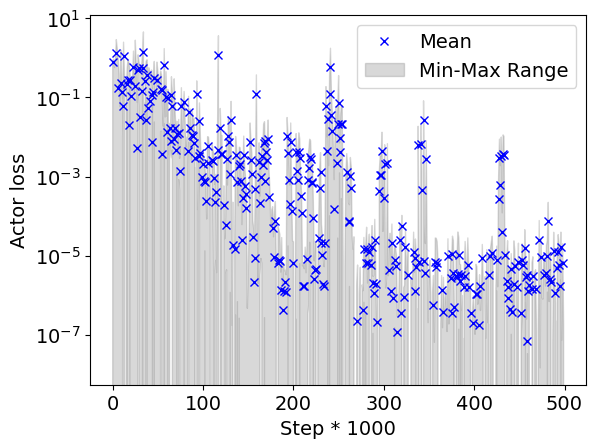

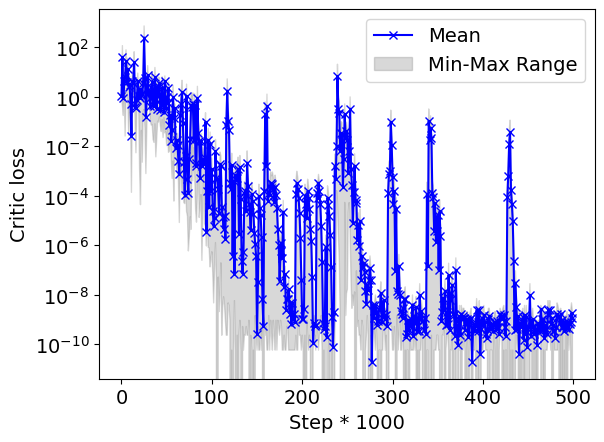

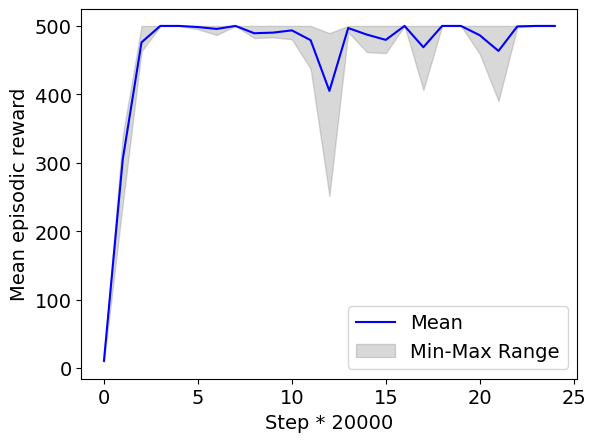

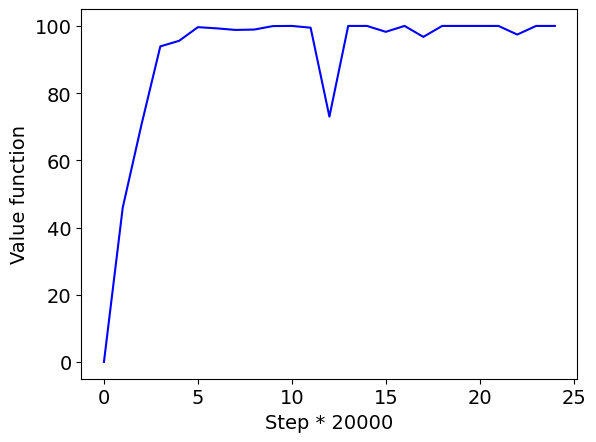

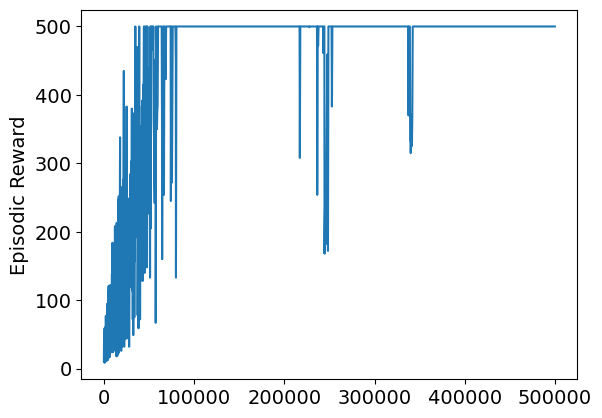

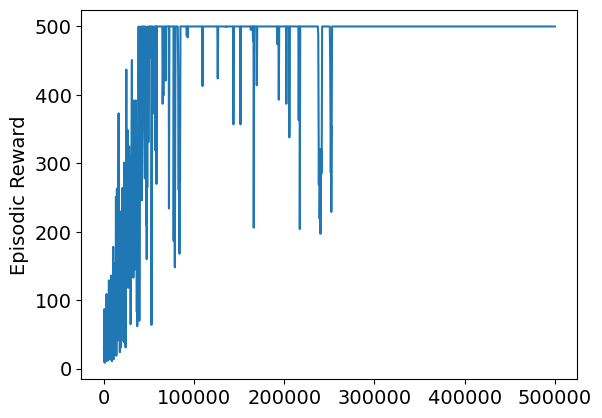

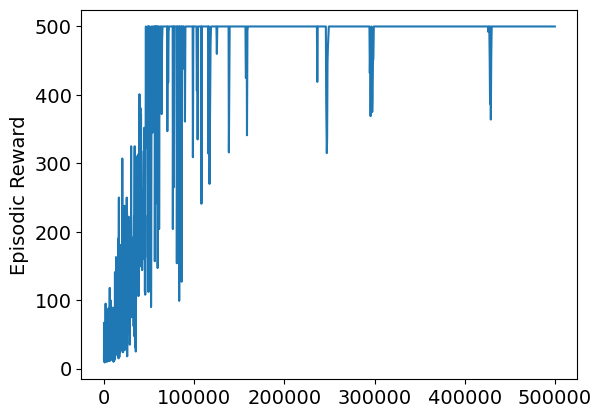

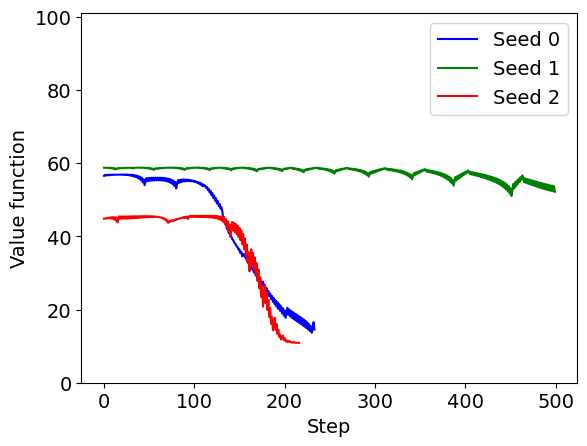

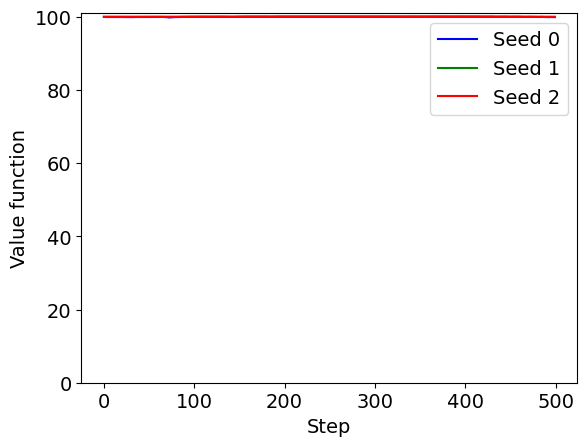

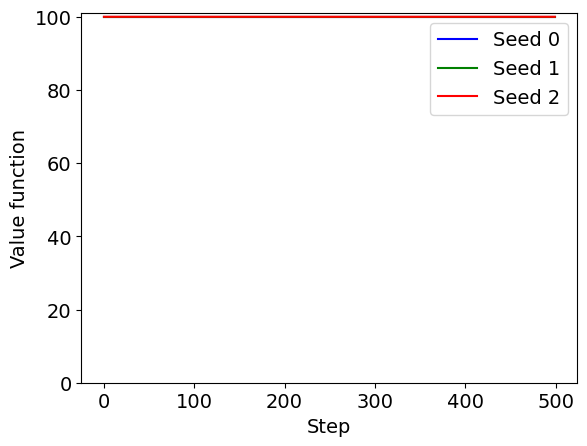

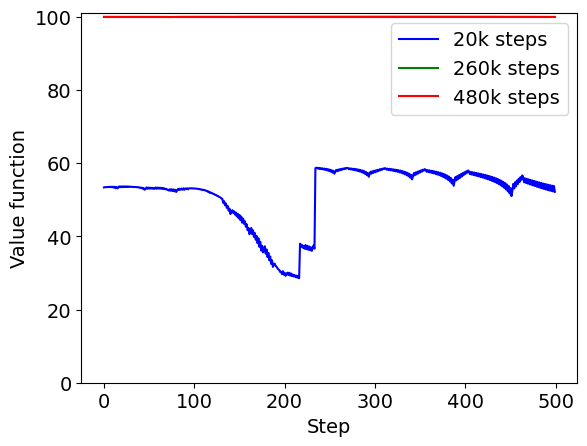

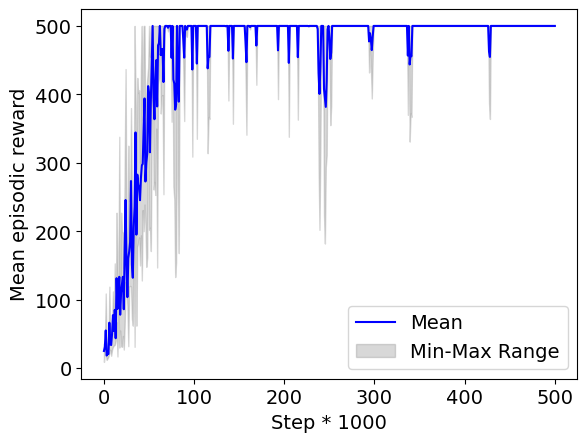

In [104]:
folder_name = 'Results_1_1_nonSparse'
plotting(folder_name, seeds) ##faire sans bootstrap !! ## 

## Agent 1 : 1env, 1step, sparse rewards

In [11]:
seeds = [52, 123, 89]
for seed in seeds:
    folder_name = 'Results_1_1_Sparse'
    if not os.path.exists(folder_name): os.makedirs(folder_name)

    filenames = [os.path.join(folder_name, str(seed)+'_1_1k.csv'), os.path.join(folder_name, str(seed)+'_1_20k_rewards.csv'), 
                 os.path.join(folder_name, str(seed)+'_1_20k_V_Values.csv'), os.path.join(folder_name, str(seed)+'_1_Ep_Rewards.csv')]

    train(seed, filenames, n_envs=1, sparse=True)

  0%|          | 0/500000 [00:00<?, ?it/s]/Users/thomasbrunet/opt/anaconda3/envs/rl_project/lib/python3.9/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
  0%|          | 25/500000 [00:00<1:01:36, 135.26it/s]

episodic return of the 20000: 9.9


  4%|▍         | 20038/500000 [01:04<42:18, 189.10it/s]  

episodic return of the 20000: 124.7


  8%|▊         | 40017/500000 [02:24<2:03:13, 62.21it/s] 

episodic return of the 20000: 287.5


 12%|█▏        | 60053/500000 [03:29<49:38, 147.71it/s]  

episodic return of the 20000: 406.0


 16%|█▌        | 80054/500000 [04:32<1:04:35, 108.37it/s]

episodic return of the 20000: 500.0


 20%|██        | 100044/500000 [05:42<1:03:27, 105.04it/s]

episodic return of the 20000: 500.0


 24%|██▍       | 120041/500000 [06:54<2:23:55, 44.00it/s] 

episodic return of the 20000: 494.4


 28%|██▊       | 140007/500000 [08:24<1:50:06, 54.49it/s] 

episodic return of the 20000: 500.0


 32%|███▏      | 160038/500000 [09:51<1:12:05, 78.59it/s]

episodic return of the 20000: 461.1


 36%|███▌      | 180031/500000 [11:18<1:00:41, 87.87it/s]

episodic return of the 20000: 300.9


 40%|████      | 200042/500000 [12:43<1:05:31, 76.30it/s]

episodic return of the 20000: 500.0


 44%|████▍     | 220031/500000 [14:11<1:18:31, 59.43it/s]

episodic return of the 20000: 495.1


 48%|████▊     | 240048/500000 [15:43<58:47, 73.70it/s]  

episodic return of the 20000: 500.0


 52%|█████▏    | 260032/500000 [17:12<1:04:16, 62.23it/s]

episodic return of the 20000: 500.0


 56%|█████▌    | 280044/500000 [18:41<49:25, 74.16it/s]  

episodic return of the 20000: 500.0


 60%|██████    | 300039/500000 [20:22<54:52, 60.74it/s]  

episodic return of the 20000: 500.0


 64%|██████▍   | 320025/500000 [22:52<1:11:08, 42.16it/s]

episodic return of the 20000: 500.0


 68%|██████▊   | 340015/500000 [24:57<1:42:50, 25.93it/s]

episodic return of the 20000: 500.0


 72%|███████▏  | 360037/500000 [26:59<51:48, 45.03it/s]  

episodic return of the 20000: 500.0


 76%|███████▌  | 380033/500000 [28:53<1:05:45, 30.41it/s]

episodic return of the 20000: 500.0


 80%|████████  | 400039/500000 [30:41<19:58, 83.38it/s]  

episodic return of the 20000: 500.0


 84%|████████▍ | 420021/500000 [32:43<31:44, 42.00it/s] 

episodic return of the 20000: 500.0


 88%|████████▊ | 440046/500000 [34:32<15:28, 64.59it/s] 

episodic return of the 20000: 500.0


 92%|█████████▏| 460039/500000 [36:07<09:51, 67.57it/s] 

episodic return of the 20000: 500.0


 96%|█████████▌| 480031/500000 [37:47<08:23, 39.65it/s] 

episodic return of the 20000: 500.0


  0%|          | 13/500000 [00:00<2:11:50, 63.20it/s]

episodic return of the 20000: 12.0


  4%|▍         | 20027/500000 [01:59<1:17:28, 103.24it/s]

episodic return of the 20000: 193.4


  8%|▊         | 40025/500000 [03:45<2:30:39, 50.88it/s] 

episodic return of the 20000: 477.0


 12%|█▏        | 60032/500000 [05:41<3:22:48, 36.16it/s] 

episodic return of the 20000: 490.6


 16%|█▌        | 80033/500000 [07:28<1:49:59, 63.63it/s] 

episodic return of the 20000: 480.5


 20%|██        | 100030/500000 [09:21<1:56:18, 57.32it/s]

episodic return of the 20000: 484.9


 24%|██▍       | 120025/500000 [10:59<1:38:35, 64.23it/s] 

episodic return of the 20000: 500.0


 28%|██▊       | 140042/500000 [12:36<1:28:24, 67.86it/s] 

episodic return of the 20000: 500.0


 32%|███▏      | 160031/500000 [14:10<1:29:56, 62.99it/s]

episodic return of the 20000: 500.0


 36%|███▌      | 180037/500000 [15:45<1:59:13, 44.73it/s]

episodic return of the 20000: 489.5


 40%|████      | 200013/500000 [17:21<1:45:26, 47.42it/s]

episodic return of the 20000: 500.0


 44%|████▍     | 220038/500000 [18:58<1:14:43, 62.44it/s]

episodic return of the 20000: 500.0


 48%|████▊     | 240028/500000 [20:37<1:05:00, 66.65it/s]

episodic return of the 20000: 494.1


 52%|█████▏    | 260029/500000 [22:11<55:42, 71.80it/s]  

episodic return of the 20000: 450.9


 56%|█████▌    | 280031/500000 [23:47<1:01:34, 59.54it/s]

episodic return of the 20000: 500.0


 60%|██████    | 300026/500000 [25:25<52:20, 63.68it/s]  

episodic return of the 20000: 500.0


 64%|██████▍   | 320025/500000 [27:01<43:44, 68.56it/s] 

episodic return of the 20000: 500.0


 68%|██████▊   | 340021/500000 [28:34<48:54, 54.51it/s] 

episodic return of the 20000: 500.0


 72%|███████▏  | 360034/500000 [30:29<39:44, 58.70it/s] 

episodic return of the 20000: 500.0


 76%|███████▌  | 380022/500000 [32:12<35:47, 55.87it/s] 

episodic return of the 20000: 500.0


 80%|████████  | 400044/500000 [33:55<26:53, 61.93it/s] 

episodic return of the 20000: 493.1


 84%|████████▍ | 420025/500000 [35:40<24:06, 55.30it/s] 

episodic return of the 20000: 500.0


 88%|████████▊ | 440030/500000 [37:26<17:15, 57.89it/s] 

episodic return of the 20000: 500.0


 92%|█████████▏| 460028/500000 [39:10<11:55, 55.83it/s] 

episodic return of the 20000: 500.0


 96%|█████████▌| 480031/500000 [40:57<06:03, 55.00it/s] 

episodic return of the 20000: 500.0


  0%|          | 32/500000 [00:00<55:59, 148.81it/s]  

episodic return of the 20000: 9.5


  4%|▍         | 20029/500000 [01:58<58:33, 136.62it/s]  

episodic return of the 20000: 94.8


  8%|▊         | 40034/500000 [03:49<2:15:36, 56.53it/s] 

episodic return of the 20000: 478.6


 12%|█▏        | 60033/500000 [05:38<3:17:20, 37.16it/s] 

episodic return of the 20000: 500.0


 16%|█▌        | 80024/500000 [07:25<2:31:49, 46.10it/s] 

episodic return of the 20000: 500.0


 20%|██        | 100023/500000 [09:09<4:58:33, 22.33it/s]

episodic return of the 20000: 488.8


 24%|██▍       | 120027/500000 [11:10<1:51:26, 56.83it/s] 

episodic return of the 20000: 495.1


 28%|██▊       | 140003/500000 [13:00<2:16:02, 44.10it/s] 

episodic return of the 20000: 500.0


 32%|███▏      | 160033/500000 [14:54<1:27:50, 64.51it/s]

episodic return of the 20000: 500.0


 36%|███▌      | 180048/500000 [16:38<1:14:42, 71.37it/s]

episodic return of the 20000: 500.0


 40%|████      | 200029/500000 [18:15<1:35:12, 52.51it/s]

episodic return of the 20000: 500.0


 44%|████▍     | 220001/500000 [19:48<1:39:51, 46.73it/s]

episodic return of the 20000: 500.0


 48%|████▊     | 240003/500000 [21:24<1:27:41, 49.41it/s]

episodic return of the 20000: 500.0


 52%|█████▏    | 260032/500000 [22:54<48:30, 82.45it/s]  

episodic return of the 20000: 500.0


 56%|█████▌    | 280039/500000 [24:18<1:04:49, 56.55it/s]

episodic return of the 20000: 500.0


 60%|██████    | 300047/500000 [25:41<39:29, 84.39it/s]  

episodic return of the 20000: 500.0


 64%|██████▍   | 320042/500000 [27:05<39:57, 75.05it/s] 

episodic return of the 20000: 500.0


 68%|██████▊   | 340038/500000 [28:45<46:53, 56.85it/s]  

episodic return of the 20000: 500.0


 72%|███████▏  | 360023/500000 [30:16<17:53, 130.43it/s]

episodic return of the 20000: 147.5


 76%|███████▌  | 380036/500000 [31:53<19:20, 103.37it/s]

episodic return of the 20000: 160.7


 80%|████████  | 400041/500000 [33:36<14:45, 112.93it/s]

episodic return of the 20000: 170.6


 84%|████████▍ | 420027/500000 [35:14<26:27, 50.36it/s] 

episodic return of the 20000: 500.0


 88%|████████▊ | 440036/500000 [36:57<17:06, 58.44it/s] 

episodic return of the 20000: 500.0


 92%|█████████▏| 460013/500000 [38:46<11:24, 58.39it/s] 

episodic return of the 20000: 137.9


 96%|█████████▌| 480028/500000 [40:30<02:16, 146.13it/s]

episodic return of the 20000: 129.9


100%|██████████| 500000/500000 [42:06<00:00, 197.92it/s]


[-0.0057239212, 2.698918751636943, 4.844839197782102, 5.437617346289752, 7.9554049026, 8.4147273248, 8.925203809000001, 10.018843944, 6.9799829957999995, 5.103292915919118, 9.387061715, 9.298894171, 9.896863132, 9.503522313000001, 8.784434570000002, 10.922096221, 11.161312457, 9.911868625999999, 8.274839247200001, 9.992460177000002, 10.917067160999999, 11.561216633, 9.525743847, 8.599823396, 11.604929936000001]


/var/folders/c4/sgxdk2g56dx90j4nw9824_sw0000gn/T/ipykernel_55758/886802808.py:65: RuntimeWarning: Mean of empty slice
  mean_v0 = np.nanmean(v0, axis=0)


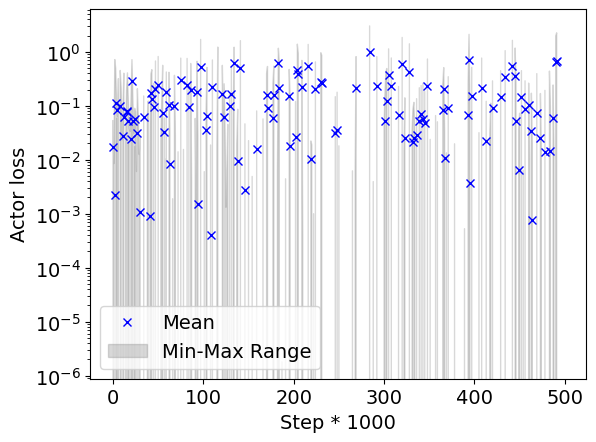

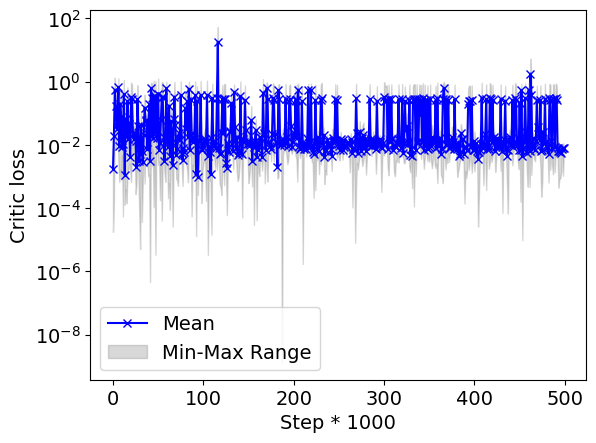

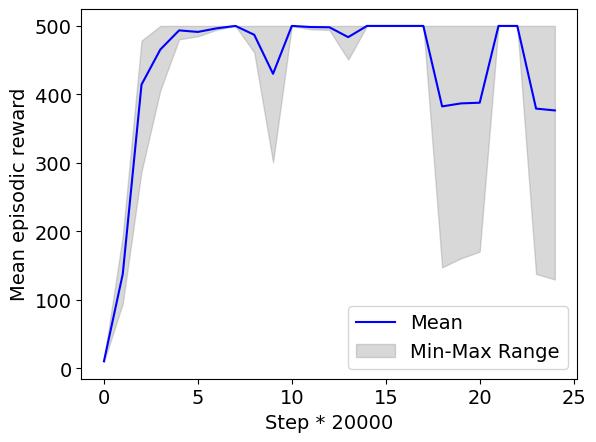

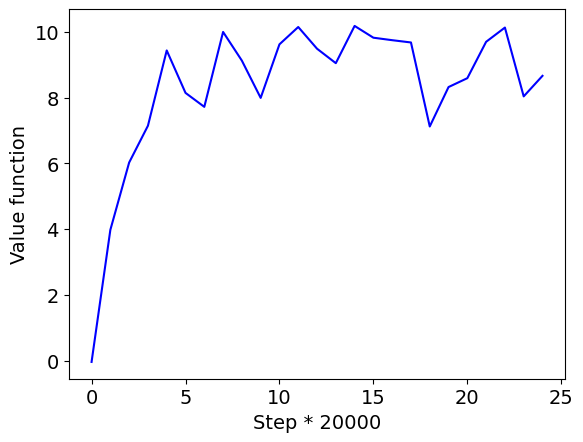

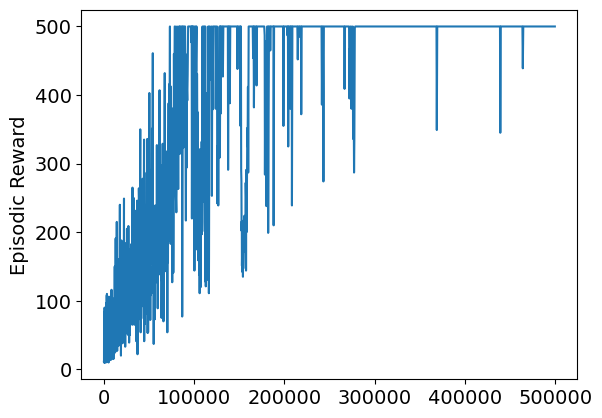

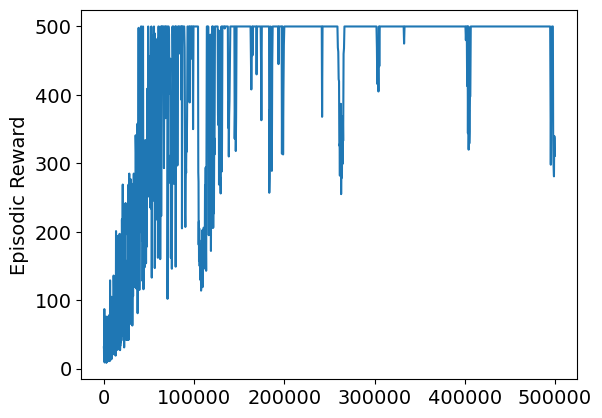

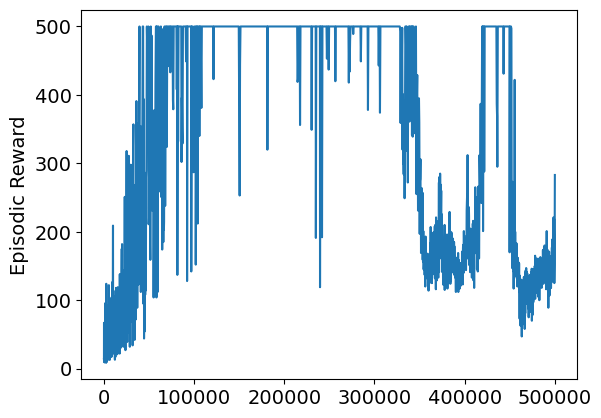

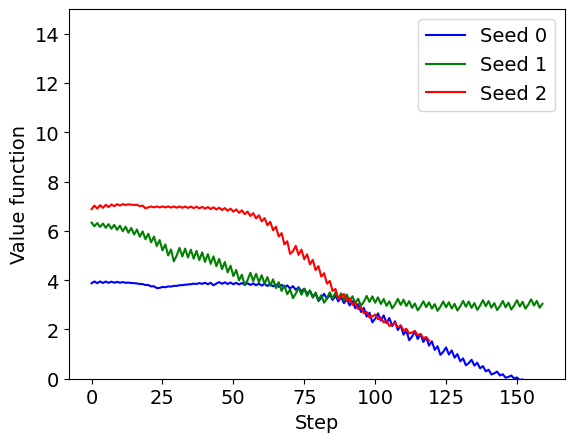

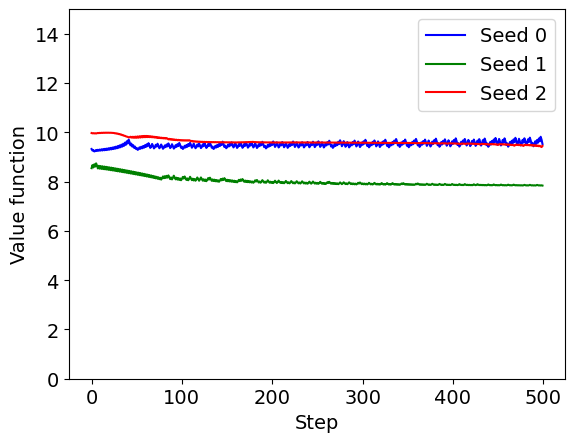

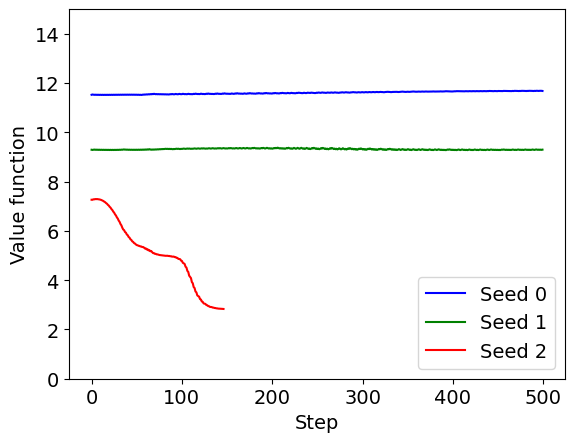

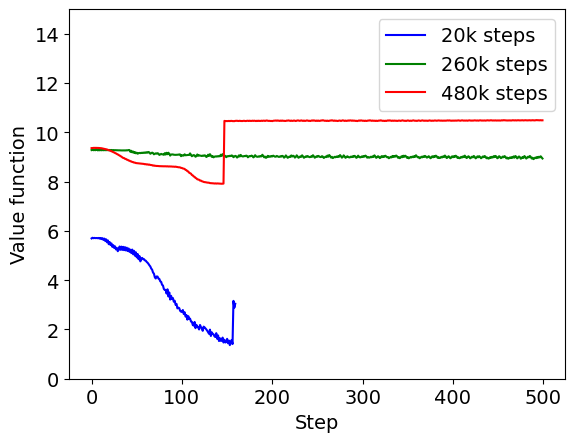

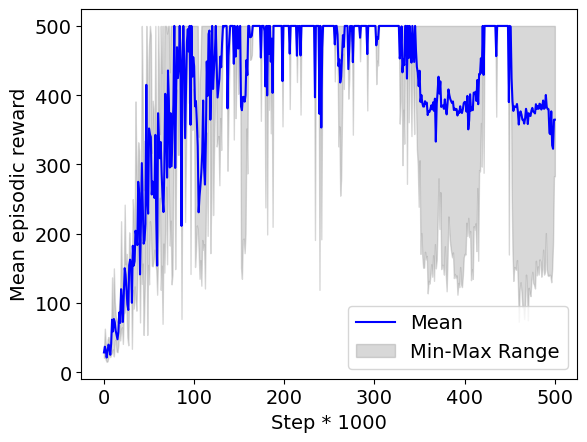

In [97]:
folder_name = 'Results_1_1_Sparse'
plotting(folder_name, seeds)

## Agent 2: 6 envs, 1 step

In [17]:
seeds = [52, 123, 89]
for seed in seeds:
    folder_name = 'Results_6env_1step'
    if not os.path.exists(folder_name): os.makedirs(folder_name)

    filenames = [os.path.join(folder_name, str(seed)+'_1_1k.csv'), os.path.join(folder_name, str(seed)+'_1_20k_rewards.csv'), 
                 os.path.join(folder_name, str(seed)+'_1_20k_V_Values.csv'), os.path.join(folder_name, str(seed)+'_1_Ep_Rewards.csv')]

    train(seed, filenames, n_envs=6, sparse=True)

  0%|          | 0/83334 [00:00<?, ?it/s]/Users/thomasbrunet/opt/anaconda3/envs/rl_project/lib/python3.9/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
  0%|          | 30/83334 [00:00<08:58, 154.82it/s]

episodic return of the 20000: 9.3


  4%|▍         | 3374/83334 [00:18<08:25, 158.10it/s]

episodic return of the 20000: 73.4


  8%|▊         | 6698/83334 [00:36<10:24, 122.71it/s]

episodic return of the 20000: 169.9


 12%|█▏        | 10023/83334 [00:53<14:51, 82.26it/s]

episodic return of the 20000: 360.8


 16%|█▌        | 13371/83334 [01:10<16:51, 69.19it/s] 

episodic return of the 20000: 497.3


 20%|█▉        | 16662/83334 [01:26<04:57, 223.95it/s]

episodic return of the 20000: 490.8


 24%|██▍       | 20025/83334 [01:48<28:05, 37.55it/s] 

episodic return of the 20000: 415.3


 28%|██▊       | 23352/83334 [02:07<20:54, 47.80it/s] 

episodic return of the 20000: 500.0


 32%|███▏      | 26698/83334 [02:26<13:48, 68.32it/s] 

episodic return of the 20000: 462.1


 36%|███▌      | 30029/83334 [02:45<14:43, 60.34it/s] 

episodic return of the 20000: 480.0


 40%|████      | 33359/83334 [03:03<13:13, 63.02it/s] 

episodic return of the 20000: 500.0


 44%|████▍     | 36697/83334 [03:22<13:26, 57.81it/s] 

episodic return of the 20000: 478.4


 48%|████▊     | 40019/83334 [03:44<16:27, 43.85it/s] 

episodic return of the 20000: 500.0


 52%|█████▏    | 43320/83334 [04:05<03:09, 210.84it/s]

episodic return of the 20000: 479.7


 56%|█████▌    | 46692/83334 [04:27<09:13, 66.23it/s] 

episodic return of the 20000: 446.2


 60%|██████    | 50016/83334 [04:46<11:11, 49.59it/s] 

episodic return of the 20000: 500.0


 64%|██████▍   | 53345/83334 [05:07<13:08, 38.02it/s] 

episodic return of the 20000: 500.0


 68%|██████▊   | 56674/83334 [05:30<08:41, 51.09it/s] 

episodic return of the 20000: 405.7


 72%|███████▏  | 60025/83334 [05:48<05:18, 73.08it/s] 

episodic return of the 20000: 467.4


 76%|███████▌  | 63361/83334 [06:08<04:44, 70.17it/s] 

episodic return of the 20000: 500.0


 80%|████████  | 66677/83334 [06:25<06:25, 43.23it/s] 

episodic return of the 20000: 500.0


 84%|████████▍ | 70030/83334 [06:45<03:56, 56.18it/s] 

episodic return of the 20000: 492.7


 88%|████████▊ | 73346/83334 [07:05<03:01, 54.92it/s] 

episodic return of the 20000: 500.0


 92%|█████████▏| 76691/83334 [07:27<01:35, 69.47it/s] 

episodic return of the 20000: 494.3


 96%|█████████▌| 80023/83334 [07:45<00:53, 61.75it/s] 

episodic return of the 20000: 500.0


100%|██████████| 83334/83334 [08:05<00:00, 171.80it/s]

episodic return of the 20000: 500.0



  0%|          | 31/83334 [00:00<08:43, 159.25it/s]

episodic return of the 20000: 13.3


  4%|▍         | 3368/83334 [00:19<10:21, 128.73it/s]

episodic return of the 20000: 108.1


  8%|▊         | 6690/83334 [00:40<16:25, 77.74it/s] 

episodic return of the 20000: 232.9


 12%|█▏        | 10032/83334 [00:57<18:41, 65.37it/s]

episodic return of the 20000: 357.0


 16%|█▌        | 13373/83334 [01:16<18:10, 64.15it/s] 

episodic return of the 20000: 453.6


 20%|██        | 16697/83334 [01:35<18:23, 60.40it/s] 

episodic return of the 20000: 483.7


 24%|██▍       | 20022/83334 [01:55<21:01, 50.18it/s] 

episodic return of the 20000: 497.6


 28%|██▊       | 23337/83334 [02:14<24:51, 40.23it/s] 

episodic return of the 20000: 493.9


 32%|███▏      | 26698/83334 [02:36<22:59, 41.04it/s] 

episodic return of the 20000: 500.0


 36%|███▌      | 30039/83334 [02:55<14:16, 62.23it/s] 

episodic return of the 20000: 494.1


 40%|████      | 33359/83334 [03:14<14:45, 56.44it/s] 

episodic return of the 20000: 490.9


 44%|████▍     | 36704/83334 [03:33<11:08, 69.78it/s] 

episodic return of the 20000: 500.0


 48%|████▊     | 40024/83334 [03:53<20:07, 35.87it/s] 

episodic return of the 20000: 500.0


 52%|█████▏    | 43345/83334 [04:13<15:58, 41.74it/s] 

episodic return of the 20000: 500.0


 56%|█████▌    | 46683/83334 [04:32<11:36, 52.60it/s] 

episodic return of the 20000: 500.0


 60%|██████    | 50020/83334 [04:50<10:10, 54.55it/s] 

episodic return of the 20000: 500.0


 64%|██████▍   | 53322/83334 [05:06<02:16, 219.12it/s]

episodic return of the 20000: 500.0


 68%|██████▊   | 56693/83334 [05:27<12:08, 36.56it/s] 

episodic return of the 20000: 500.0


 72%|███████▏  | 60018/83334 [05:51<06:54, 56.28it/s] 

episodic return of the 20000: 500.0


 76%|███████▌  | 63354/83334 [06:12<08:12, 40.53it/s] 

episodic return of the 20000: 496.9


 80%|████████  | 66689/83334 [06:34<05:25, 51.06it/s] 

episodic return of the 20000: 500.0


 84%|████████▍ | 70016/83334 [06:52<03:39, 60.64it/s] 

episodic return of the 20000: 460.8


 88%|████████▊ | 73340/83334 [07:14<05:08, 32.35it/s] 

episodic return of the 20000: 500.0


 92%|█████████▏| 76690/83334 [07:34<01:58, 55.90it/s] 

episodic return of the 20000: 500.0


 96%|█████████▌| 80029/83334 [07:54<00:56, 58.95it/s] 

episodic return of the 20000: 500.0


100%|██████████| 83334/83334 [08:14<00:00, 168.43it/s]

episodic return of the 20000: 495.6



  0%|          | 27/83334 [00:00<09:46, 142.14it/s]

episodic return of the 20000: 9.5


  4%|▍         | 3353/83334 [00:19<11:46, 113.17it/s]

episodic return of the 20000: 78.9


  8%|▊         | 6701/83334 [00:38<13:01, 98.05it/s] 

episodic return of the 20000: 217.8


 12%|█▏        | 10024/83334 [00:58<27:11, 44.93it/s]

episodic return of the 20000: 446.3


 16%|█▌        | 13364/83334 [01:18<22:47, 51.16it/s] 

episodic return of the 20000: 488.6


 20%|██        | 16690/83334 [01:42<19:27, 57.08it/s] 

episodic return of the 20000: 481.7


 24%|██▍       | 20020/83334 [02:02<23:57, 44.05it/s] 

episodic return of the 20000: 500.0


 28%|██▊       | 23356/83334 [02:21<21:13, 47.09it/s] 

episodic return of the 20000: 500.0


 32%|███▏      | 26680/83334 [02:40<21:06, 44.75it/s] 

episodic return of the 20000: 500.0


 36%|███▌      | 30019/83334 [02:59<14:33, 61.02it/s] 

episodic return of the 20000: 493.0


 40%|████      | 33355/83334 [03:17<15:45, 52.88it/s] 

episodic return of the 20000: 500.0


 44%|████▍     | 36669/83334 [03:37<25:04, 31.01it/s] 

episodic return of the 20000: 485.8


 48%|████▊     | 40012/83334 [03:56<22:42, 31.79it/s] 

episodic return of the 20000: 489.2


 52%|█████▏    | 43353/83334 [04:16<10:51, 61.34it/s] 

episodic return of the 20000: 500.0


 56%|█████▌    | 46700/83334 [04:37<10:12, 59.80it/s] 

episodic return of the 20000: 500.0


 60%|█████▉    | 49988/83334 [04:55<03:00, 184.73it/s]

episodic return of the 20000: 500.0


 64%|██████▍   | 53353/83334 [05:17<14:31, 34.39it/s] 

episodic return of the 20000: 500.0


 68%|██████▊   | 56689/83334 [05:37<05:27, 81.41it/s] 

episodic return of the 20000: 285.0


 72%|███████▏  | 60018/83334 [05:57<07:22, 52.73it/s] 

episodic return of the 20000: 500.0


 76%|███████▌  | 63362/83334 [06:16<05:59, 55.60it/s] 

episodic return of the 20000: 500.0


 80%|████████  | 66678/83334 [06:35<05:43, 48.42it/s] 

episodic return of the 20000: 429.5


 84%|████████▍ | 70024/83334 [06:58<03:58, 55.74it/s] 

episodic return of the 20000: 500.0


 88%|████████▊ | 73360/83334 [07:17<02:57, 56.31it/s] 

episodic return of the 20000: 500.0


 92%|█████████▏| 76680/83334 [07:37<01:56, 56.97it/s] 

episodic return of the 20000: 500.0


 96%|█████████▌| 80018/83334 [07:56<00:56, 59.10it/s] 

episodic return of the 20000: 500.0


100%|██████████| 83334/83334 [08:15<00:00, 168.28it/s]

episodic return of the 20000: 500.0


[0.10665470319999999, 2.268409463125, 3.044034708120755, 3.9795539854, 7.4505010365999995, 9.451023666, 8.055639660041841, 9.629950444, 9.377191762999999, 9.613253113999999, 10.142014042000001, 9.870603758, 10.365718220000002, 9.389254382, 8.702830518465227, 10.991377942000002, 8.828914265, 9.251931006650246, 9.74216680770975, 10.064999272, 9.393538578, 8.95016003, 10.107447389999999, 9.986297108352145, 10.469511203, 9.994435305]


/var/folders/c4/sgxdk2g56dx90j4nw9824_sw0000gn/T/ipykernel_55758/886802808.py:65: RuntimeWarning: Mean of empty slice
  mean_v0 = np.nanmean(v0, axis=0)


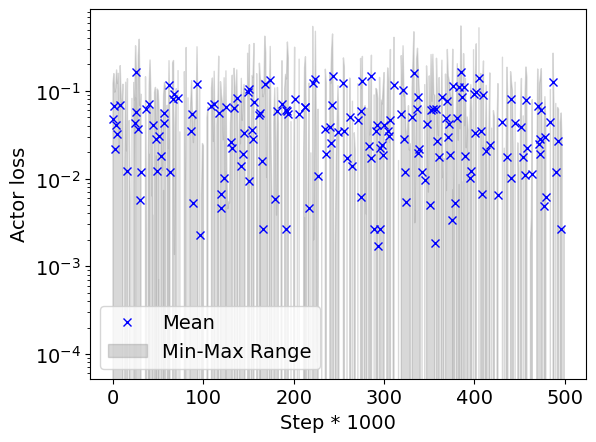

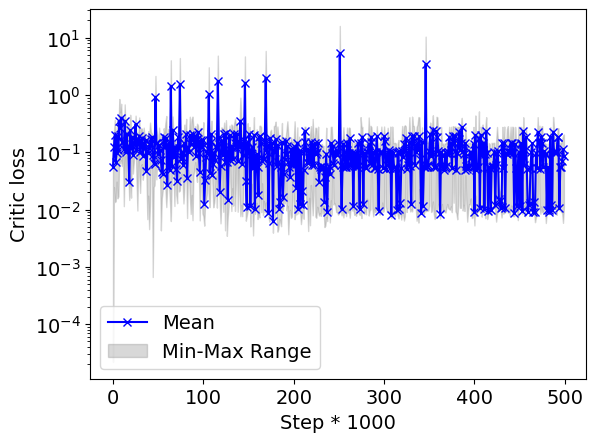

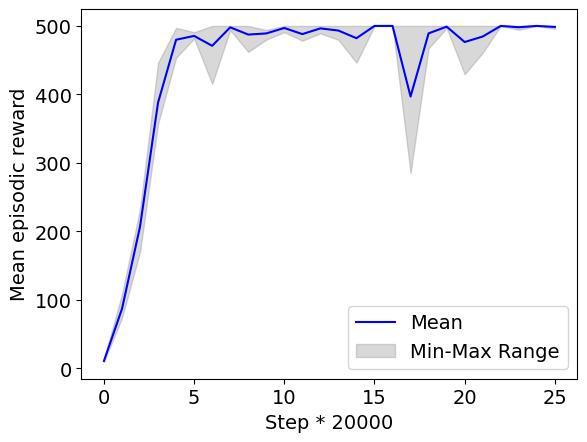

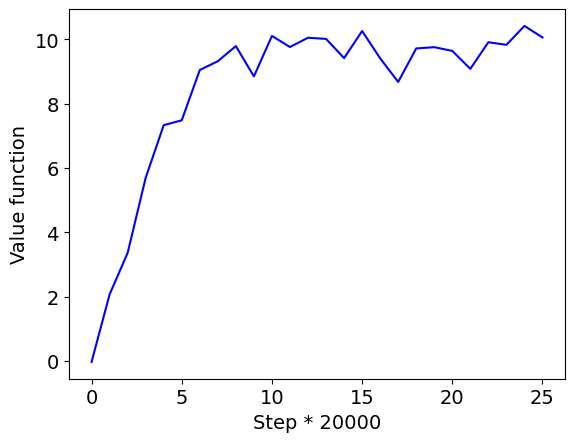

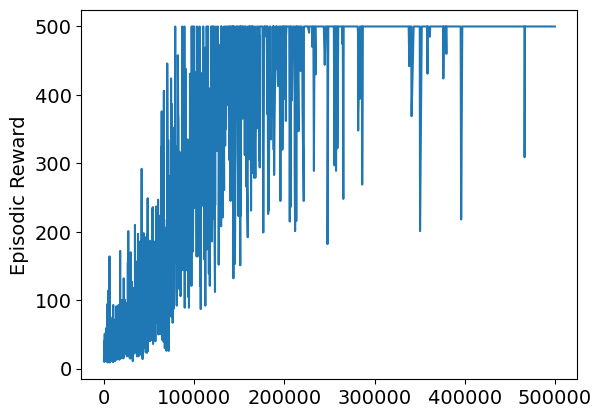

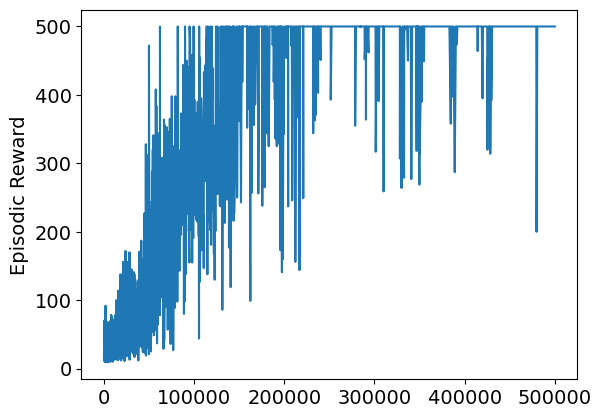

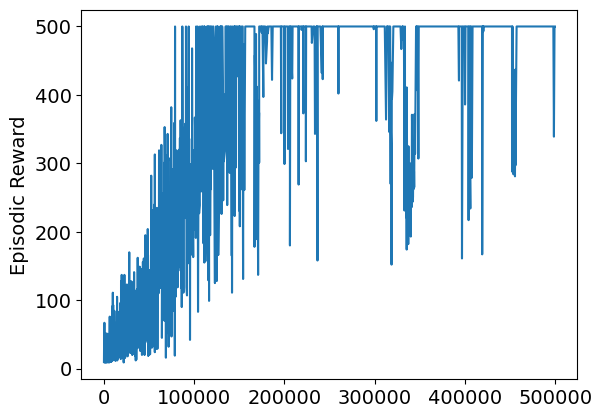

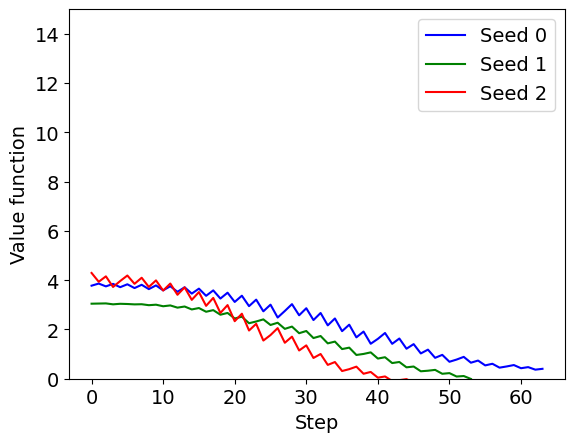

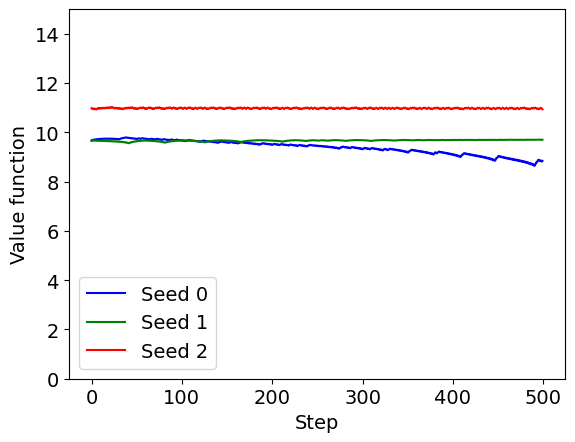

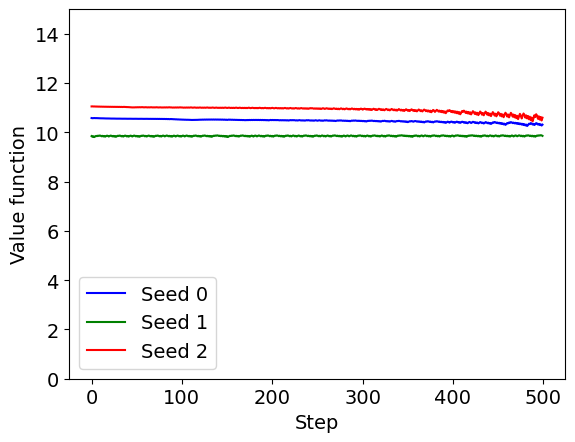

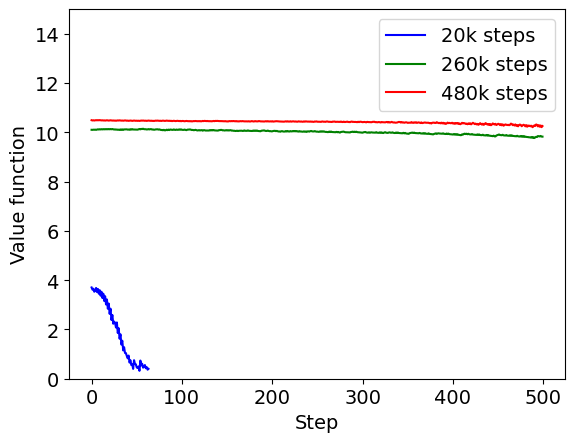

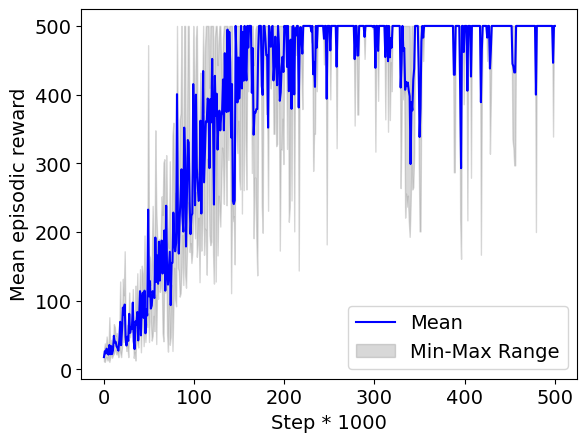

In [99]:
folder_name = 'Results_6env_1step'
plotting(folder_name, seeds)

## Agent 3: 1 env, 6 steps

In [19]:
seeds = [52, 123, 89]
for seed in seeds:
    folder_name = 'Results_1env_6step'
    if not os.path.exists(folder_name): os.makedirs(folder_name)

    filenames = [os.path.join(folder_name, str(seed)+'_1_1k.csv'), os.path.join(folder_name, str(seed)+'_1_20k_rewards.csv'), 
                 os.path.join(folder_name, str(seed)+'_1_20k_V_Values.csv'), os.path.join(folder_name, str(seed)+'_1_Ep_Rewards.csv')]

    train_n(seed, filenames, n_envs=1, n_steps=6, sparse=True)

  0%|          | 0/83334 [00:00<?, ?it/s]/Users/thomasbrunet/opt/anaconda3/envs/rl_project/lib/python3.9/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
  0%|          | 10/83334 [00:00<28:33, 48.62it/s]

episodic return of the 20000: 9.0


  4%|▍         | 3343/83334 [00:54<26:26, 50.43it/s]

episodic return of the 20000: 76.4


  8%|▊         | 6677/83334 [01:50<41:55, 30.47it/s]

episodic return of the 20000: 119.9


 12%|█▏        | 10008/83334 [02:51<1:07:55, 17.99it/s]

episodic return of the 20000: 223.3


 16%|█▌        | 13339/83334 [03:50<1:08:35, 17.01it/s]

episodic return of the 20000: 370.3


 20%|██        | 16678/83334 [04:46<1:19:31, 13.97it/s]

episodic return of the 20000: 500.0


 24%|██▍       | 20009/83334 [05:42<1:26:41, 12.17it/s]

episodic return of the 20000: 457.2


 28%|██▊       | 23330/83334 [06:33<14:07, 70.81it/s]  

episodic return of the 20000: 441.7


 32%|███▏      | 26673/83334 [07:29<58:08, 16.24it/s]  

episodic return of the 20000: 500.0


 36%|███▌      | 30004/83334 [08:24<1:04:46, 13.72it/s]

episodic return of the 20000: 476.6


 40%|████      | 33335/83334 [09:17<48:13, 17.28it/s]  

episodic return of the 20000: 500.0


 44%|████▍     | 36663/83334 [10:13<11:00, 70.68it/s]

episodic return of the 20000: 441.2


 48%|████▊     | 40005/83334 [11:10<47:43, 15.13it/s]

episodic return of the 20000: 500.0


 52%|█████▏    | 43339/83334 [12:04<33:17, 20.02it/s]

episodic return of the 20000: 500.0


 56%|█████▌    | 46665/83334 [13:02<47:01, 13.00it/s]

episodic return of the 20000: 500.0


 60%|██████    | 50008/83334 [13:57<22:38, 24.53it/s]

episodic return of the 20000: 438.3


 64%|██████▍   | 53332/83334 [14:54<36:05, 13.86it/s]

episodic return of the 20000: 500.0


 68%|██████▊   | 56667/83334 [15:52<46:26,  9.57it/s]

episodic return of the 20000: 500.0


 72%|███████▏  | 59995/83334 [16:47<33:36, 11.58it/s]

episodic return of the 20000: 500.0


 76%|███████▌  | 63330/83334 [17:41<23:09, 14.40it/s]

episodic return of the 20000: 500.0


 80%|███████▉  | 66667/83334 [18:38<20:21, 13.65it/s]

episodic return of the 20000: 500.0


 84%|████████▍ | 69999/83334 [19:33<14:55, 14.89it/s]

episodic return of the 20000: 500.0


 88%|████████▊ | 73327/83334 [20:24<19:54,  8.38it/s]

episodic return of the 20000: 500.0


 92%|█████████▏| 76662/83334 [21:23<06:04, 18.31it/s]

episodic return of the 20000: 500.0


 96%|█████████▌| 79993/83334 [22:21<05:36,  9.93it/s]

episodic return of the 20000: 500.0


100%|█████████▉| 83325/83334 [23:18<00:00, 65.51it/s]

episodic return of the 20000: 500.0


  0%|          | 10/83334 [00:00<28:28, 48.76it/s]

episodic return of the 20000: 13.0


  4%|▍         | 3343/83334 [00:58<32:01, 41.63it/s] 

episodic return of the 20000: 104.5


  8%|▊         | 6676/83334 [01:53<38:35, 33.11it/s]

episodic return of the 20000: 161.0


 12%|█▏        | 10006/83334 [02:47<56:24, 21.66it/s]  

episodic return of the 20000: 245.5


 16%|█▌        | 13341/83334 [03:42<55:13, 21.12it/s]  

episodic return of the 20000: 464.6


 20%|██        | 16679/83334 [04:35<37:48, 29.39it/s]

episodic return of the 20000: 342.7


 24%|██▍       | 20005/83334 [05:30<44:25, 23.76it/s]

episodic return of the 20000: 393.8


 28%|██▊       | 23341/83334 [06:25<54:17, 18.42it/s]  

episodic return of the 20000: 454.0


 32%|███▏      | 26671/83334 [07:24<58:49, 16.05it/s]

episodic return of the 20000: 471.5


 36%|███▌      | 30008/83334 [08:16<46:59, 18.92it/s]

episodic return of the 20000: 500.0


 40%|████      | 33335/83334 [09:17<49:22, 16.88it/s]

episodic return of the 20000: 500.0


 44%|████▍     | 36667/83334 [10:13<42:26, 18.33it/s]

episodic return of the 20000: 467.7


 48%|████▊     | 40001/83334 [11:06<1:02:19, 11.59it/s]

episodic return of the 20000: 500.0


 52%|█████▏    | 43333/83334 [12:06<1:05:23, 10.19it/s]

episodic return of the 20000: 500.0


 56%|█████▌    | 46662/83334 [13:01<10:00, 61.03it/s]  

episodic return of the 20000: 500.0


 60%|█████▉    | 50000/83334 [13:54<34:13, 16.23it/s]

episodic return of the 20000: 488.4


 64%|██████▍   | 53335/83334 [14:47<25:46, 19.40it/s]

episodic return of the 20000: 500.0


 68%|██████▊   | 56667/83334 [15:43<34:26, 12.91it/s]

episodic return of the 20000: 500.0


 72%|███████▏  | 60000/83334 [16:37<36:04, 10.78it/s]

episodic return of the 20000: 500.0


 76%|███████▌  | 63330/83334 [17:29<19:59, 16.68it/s]

episodic return of the 20000: 500.0


 80%|███████▉  | 66664/83334 [18:27<19:30, 14.24it/s]

episodic return of the 20000: 500.0


 84%|████████▍ | 70000/83334 [19:22<10:55, 20.36it/s]

episodic return of the 20000: 500.0


 88%|████████▊ | 73327/83334 [20:17<19:51,  8.40it/s]

episodic return of the 20000: 500.0


 92%|█████████▏| 76667/83334 [21:09<06:10, 18.01it/s]

episodic return of the 20000: 500.0


 96%|█████████▌| 80000/83334 [22:04<03:03, 18.13it/s]

episodic return of the 20000: 484.2


100%|█████████▉| 83326/83334 [22:57<00:00, 13.73it/s]

episodic return of the 20000: 500.0


  0%|          | 13/83334 [00:00<22:56, 60.54it/s]

episodic return of the 20000: 9.6


  4%|▍         | 3343/83334 [00:52<25:21, 52.59it/s]

episodic return of the 20000: 71.8


  8%|▊         | 6675/83334 [01:45<31:56, 40.00it/s]

episodic return of the 20000: 194.5


 12%|█▏        | 10011/83334 [02:40<45:11, 27.04it/s]

episodic return of the 20000: 330.8


 16%|█▌        | 13344/83334 [03:34<47:09, 24.74it/s]

episodic return of the 20000: 311.6


 20%|██        | 16673/83334 [04:29<1:37:04, 11.45it/s]

episodic return of the 20000: 467.0


 24%|██▍       | 19998/83334 [05:20<17:39, 59.77it/s]  

episodic return of the 20000: 481.4


 28%|██▊       | 23334/83334 [06:22<1:48:44,  9.20it/s]

episodic return of the 20000: 481.6


 32%|███▏      | 26675/83334 [07:28<1:10:10, 13.46it/s]

episodic return of the 20000: 485.9


 36%|███▌      | 30010/83334 [08:35<43:10, 20.59it/s]  

episodic return of the 20000: 500.0


 40%|████      | 33334/83334 [09:27<55:30, 15.01it/s]

episodic return of the 20000: 500.0


 44%|████▍     | 36666/83334 [10:24<54:21, 14.31it/s]

episodic return of the 20000: 500.0


 48%|████▊     | 39998/83334 [11:18<44:14, 16.32it/s]

episodic return of the 20000: 475.1


 52%|█████▏    | 43335/83334 [12:12<37:45, 17.66it/s]

episodic return of the 20000: 500.0


 56%|█████▌    | 46671/83334 [13:04<32:25, 18.84it/s]

episodic return of the 20000: 500.0


 60%|██████    | 50002/83334 [13:56<27:09, 20.46it/s]

episodic return of the 20000: 500.0


 64%|██████▍   | 53339/83334 [15:08<28:20, 17.64it/s]  

episodic return of the 20000: 500.0


 68%|██████▊   | 56674/83334 [16:06<26:08, 17.00it/s]

episodic return of the 20000: 500.0


 72%|███████▏  | 60004/83334 [17:04<37:19, 10.42it/s]

episodic return of the 20000: 500.0


 76%|███████▌  | 63332/83334 [17:59<27:35, 12.08it/s]

episodic return of the 20000: 500.0


 80%|████████  | 66670/83334 [18:55<14:11, 19.57it/s]

episodic return of the 20000: 484.0


 84%|████████▍ | 70008/83334 [19:51<10:34, 21.01it/s]

episodic return of the 20000: 500.0


 88%|████████▊ | 73328/83334 [20:44<10:54, 15.29it/s]

episodic return of the 20000: 500.0


 92%|█████████▏| 76668/83334 [21:41<06:02, 18.39it/s]

episodic return of the 20000: 500.0


 96%|█████████▌| 80005/83334 [22:36<02:28, 22.45it/s]

episodic return of the 20000: 500.0


100%|██████████| 83334/83334 [23:31<00:00, 59.06it/s]

episodic return of the 20000: 500.0


[0.014209946570000001, 2.697998557142857, 3.2767598625806453, 2.5897270376846473, 3.5800743680350875, 5.0895962491999995, 7.2101895104, 8.454136741000001, 7.104586089400001, 8.2333742742, 10.146757614, 7.525526764, 10.028644871000001, 8.946994661000002, 10.159462726, 8.459068917407407, 10.668226415000001, 9.208781299, 10.325693488, 9.610210699, 9.648480674, 9.138618172000001, 9.679472556999999, 10.254809017000001, 10.586012074000001, 9.364843166]


/var/folders/c4/sgxdk2g56dx90j4nw9824_sw0000gn/T/ipykernel_55758/886802808.py:65: RuntimeWarning: Mean of empty slice
  mean_v0 = np.nanmean(v0, axis=0)


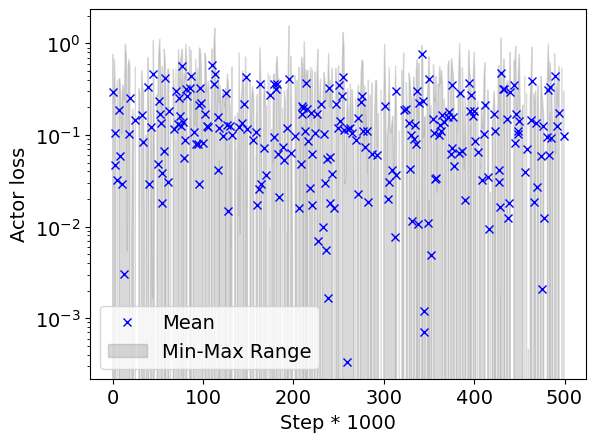

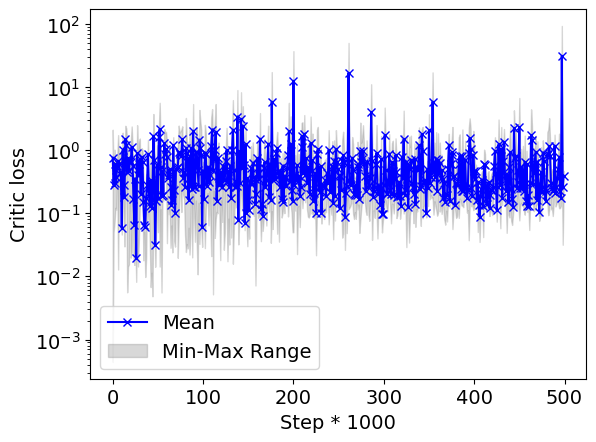

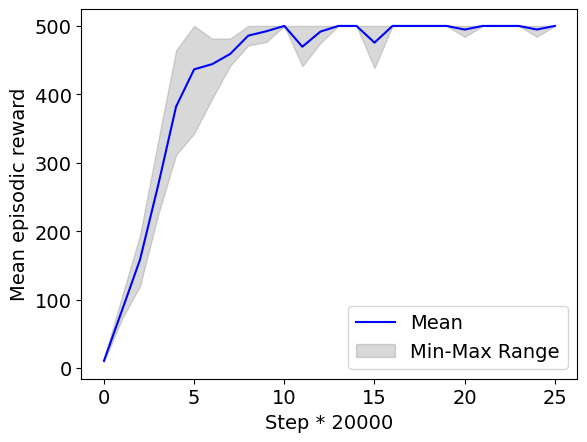

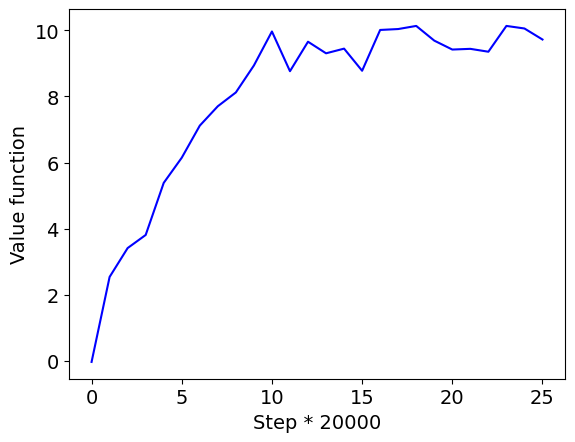

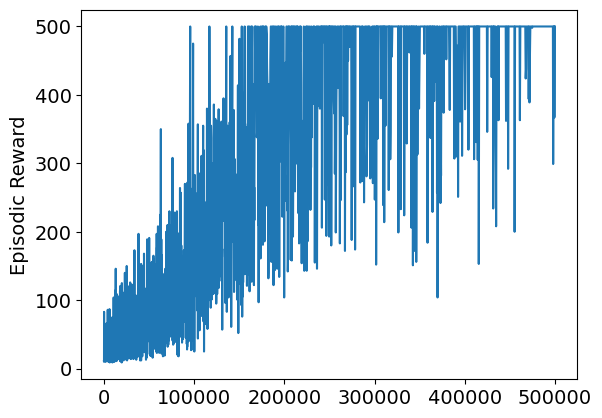

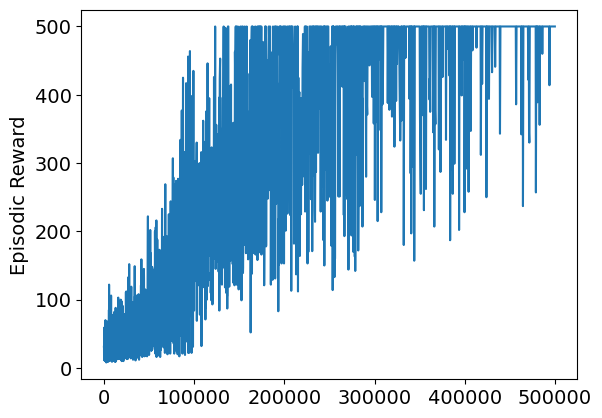

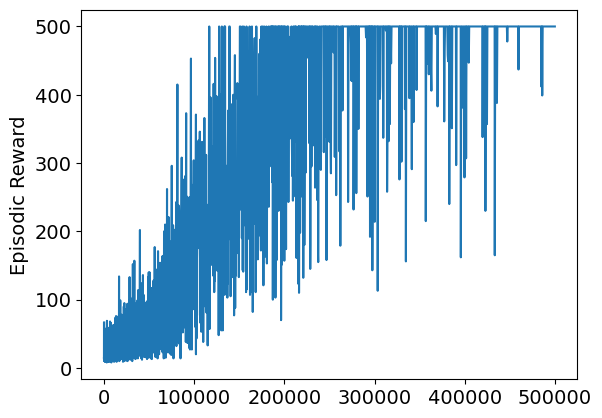

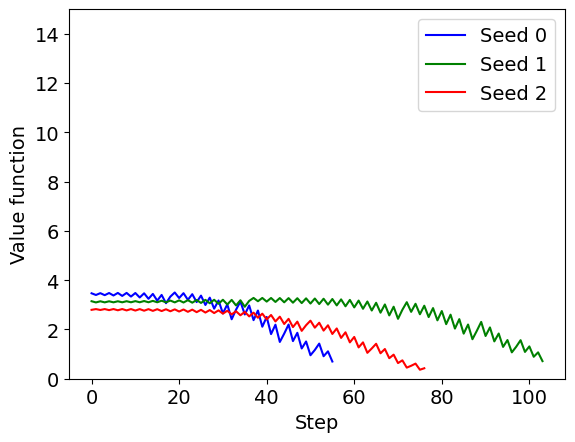

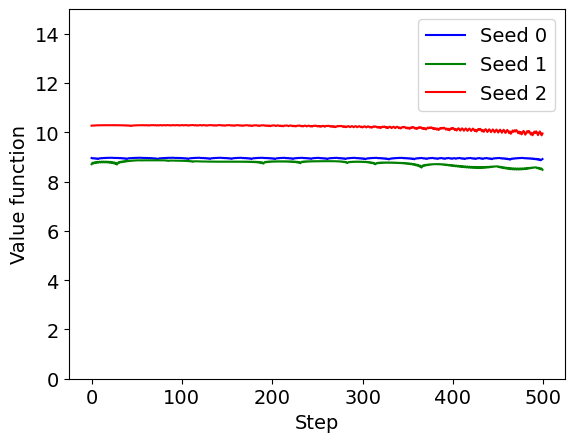

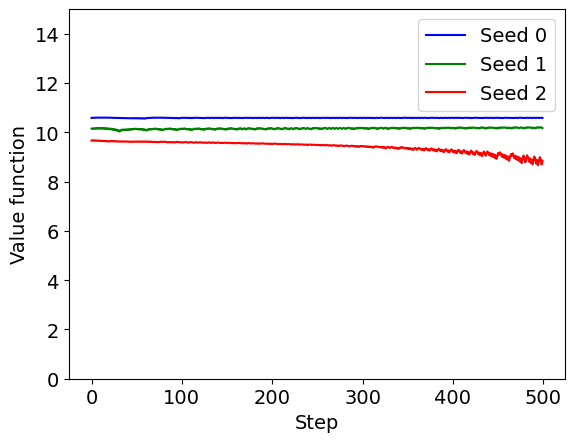

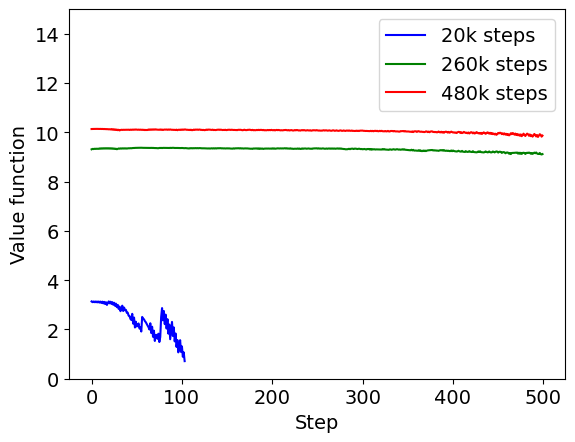

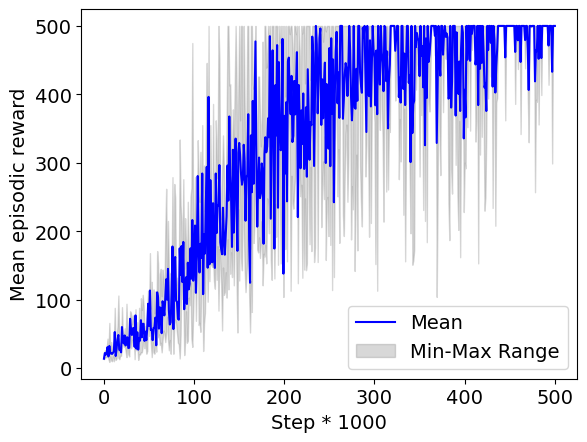

In [100]:
folder_name = 'Results_1env_6step'
plotting(folder_name, seeds)

## Agent 4: 6 env, 6 steps

In [21]:
seeds = [52, 123, 89]
for seed in seeds:
    folder_name = 'Results_6env_6step'
    if not os.path.exists(folder_name): os.makedirs(folder_name)

    filenames = [os.path.join(folder_name, str(seed)+'_1_1k.csv'), os.path.join(folder_name, str(seed)+'_1_20k_rewards.csv'), 
                 os.path.join(folder_name, str(seed)+'_1_20k_V_Values.csv'), os.path.join(folder_name, str(seed)+'_1_Ep_Rewards.csv')]

    train_n(seed, filenames, n_envs=6, n_steps=6, sparse=True)

  0%|          | 0/13889 [00:00<?, ?it/s]/Users/thomasbrunet/opt/anaconda3/envs/rl_project/lib/python3.9/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
  0%|          | 5/13889 [00:00<12:00, 19.27it/s]

episodic return of the 20000: 9.5


  4%|▍         | 564/13889 [00:17<05:58, 37.14it/s]

episodic return of the 20000: 54.3


  8%|▊         | 1121/13889 [00:30<06:41, 31.78it/s]

episodic return of the 20000: 85.8


 12%|█▏        | 1675/13889 [00:45<07:04, 28.76it/s]

episodic return of the 20000: 84.7


 16%|█▌        | 2231/13889 [00:58<06:44, 28.85it/s]

episodic return of the 20000: 138.2


 20%|██        | 2787/13889 [01:11<05:34, 33.19it/s]

episodic return of the 20000: 107.5


 24%|██▍       | 3343/13889 [01:25<06:08, 28.63it/s]

episodic return of the 20000: 121.3


 28%|██▊       | 3898/13889 [01:39<07:16, 22.90it/s]

episodic return of the 20000: 194.9


 32%|███▏      | 4455/13889 [01:52<06:37, 23.73it/s]

episodic return of the 20000: 215.4


 36%|███▌      | 5010/13889 [02:05<06:07, 24.16it/s]

episodic return of the 20000: 228.6


 40%|████      | 5565/13889 [02:19<08:50, 15.68it/s]

episodic return of the 20000: 273.7


 44%|████▍     | 6124/13889 [02:32<12:28, 10.37it/s]

episodic return of the 20000: 403.7


 48%|████▊     | 6677/13889 [02:45<11:00, 10.91it/s]

episodic return of the 20000: 445.3


 52%|█████▏    | 7233/13889 [03:01<08:15, 13.45it/s]

episodic return of the 20000: 500.0


 56%|█████▌    | 7791/13889 [03:20<10:36,  9.57it/s]

episodic return of the 20000: 485.5


 60%|██████    | 8346/13889 [03:37<07:15, 12.74it/s]

episodic return of the 20000: 488.8


 64%|██████▍   | 8904/13889 [03:52<04:21, 19.06it/s]

episodic return of the 20000: 366.4


 68%|██████▊   | 9458/13889 [04:05<04:59, 14.82it/s]

episodic return of the 20000: 484.6


 72%|███████▏  | 10012/13889 [04:19<05:35, 11.57it/s]

episodic return of the 20000: 483.8


 76%|███████▌  | 10569/13889 [04:32<04:00, 13.79it/s]

episodic return of the 20000: 500.0


 80%|████████  | 11127/13889 [04:46<03:22, 13.65it/s]

episodic return of the 20000: 490.2


 84%|████████▍ | 11683/13889 [05:00<02:57, 12.44it/s]

episodic return of the 20000: 500.0


 88%|████████▊ | 12237/13889 [05:15<03:42,  7.44it/s]

episodic return of the 20000: 497.1


 92%|█████████▏| 12794/13889 [05:31<01:55,  9.48it/s]

episodic return of the 20000: 500.0


 96%|█████████▌| 13350/13889 [05:44<00:45, 11.90it/s]

episodic return of the 20000: 500.0


  0%|          | 4/13889 [00:00<11:35, 19.96it/s]

episodic return of the 20000: 11.6


  4%|▍         | 565/13889 [00:13<07:46, 28.53it/s]

episodic return of the 20000: 97.9


  8%|▊         | 1122/13889 [00:28<06:47, 31.32it/s]

episodic return of the 20000: 90.9


 12%|█▏        | 1678/13889 [00:42<06:43, 30.24it/s]

episodic return of the 20000: 109.7


 16%|█▌        | 2234/13889 [00:55<06:57, 27.89it/s]

episodic return of the 20000: 150.6


 20%|██        | 2787/13889 [01:09<06:21, 29.13it/s]

episodic return of the 20000: 157.1


 24%|██▍       | 3346/13889 [01:23<06:02, 29.07it/s]

episodic return of the 20000: 173.1


 28%|██▊       | 3896/13889 [01:36<14:47, 11.27it/s]

episodic return of the 20000: 206.8


 32%|███▏      | 4454/13889 [01:50<08:28, 18.54it/s]

episodic return of the 20000: 268.1


 36%|███▌      | 5012/13889 [02:04<07:55, 18.67it/s]

episodic return of the 20000: 409.3


 40%|████      | 5569/13889 [02:18<08:34, 16.18it/s]

episodic return of the 20000: 361.3


 44%|████▍     | 6117/13889 [02:31<11:59, 10.80it/s]

episodic return of the 20000: 390.2


 48%|████▊     | 6679/13889 [02:45<07:12, 16.67it/s]

episodic return of the 20000: 417.5


 52%|█████▏    | 7231/13889 [03:00<10:59, 10.09it/s]

episodic return of the 20000: 467.8


 56%|█████▌    | 7786/13889 [03:14<07:00, 14.52it/s]

episodic return of the 20000: 420.4


 60%|██████    | 8351/13889 [03:27<05:28, 16.88it/s]

episodic return of the 20000: 482.3


 64%|██████▍   | 8900/13889 [03:41<08:43,  9.53it/s]

episodic return of the 20000: 456.9


 68%|██████▊   | 9452/13889 [03:53<01:30, 48.86it/s]

episodic return of the 20000: 476.6


 72%|███████▏  | 10018/13889 [04:08<03:47, 16.98it/s]

episodic return of the 20000: 474.2


 76%|███████▌  | 10572/13889 [04:22<03:50, 14.37it/s]

episodic return of the 20000: 500.0


 80%|████████  | 11127/13889 [04:36<05:33,  8.28it/s]

episodic return of the 20000: 493.6


 84%|████████▍ | 11682/13889 [04:52<05:17,  6.96it/s]

episodic return of the 20000: 494.9


 88%|████████▊ | 12237/13889 [05:09<02:36, 10.53it/s]

episodic return of the 20000: 500.0


 92%|█████████▏| 12797/13889 [05:23<01:12, 15.07it/s]

episodic return of the 20000: 500.0


 96%|█████████▌| 13348/13889 [05:37<00:46, 11.68it/s]

episodic return of the 20000: 500.0


  0%|          | 4/13889 [00:00<15:21, 15.07it/s]

episodic return of the 20000: 9.3


  4%|▍         | 560/13889 [00:13<06:19, 35.13it/s]

episodic return of the 20000: 29.1


  8%|▊         | 1119/13889 [00:27<05:49, 36.54it/s]

episodic return of the 20000: 61.8


 12%|█▏        | 1674/13889 [00:41<09:21, 21.74it/s]

episodic return of the 20000: 206.3


 16%|█▌        | 2229/13889 [00:55<16:45, 11.60it/s]

episodic return of the 20000: 270.2


 20%|██        | 2785/13889 [01:09<11:50, 15.63it/s]

episodic return of the 20000: 268.8


 24%|██▍       | 3344/13889 [01:23<08:44, 20.10it/s]

episodic return of the 20000: 274.2


 28%|██▊       | 3903/13889 [01:37<06:17, 26.42it/s]

episodic return of the 20000: 194.4


 32%|███▏      | 4456/13889 [01:49<05:45, 27.30it/s]

episodic return of the 20000: 158.4


 36%|███▌      | 5011/13889 [02:03<06:47, 21.78it/s]

episodic return of the 20000: 279.3


 40%|████      | 5564/13889 [02:19<28:35,  4.85it/s]

episodic return of the 20000: 441.7


 44%|████▍     | 6123/13889 [02:34<09:43, 13.30it/s]

episodic return of the 20000: 439.3


 48%|████▊     | 6678/13889 [02:48<08:11, 14.68it/s]

episodic return of the 20000: 430.6


 52%|█████▏    | 7236/13889 [03:01<07:25, 14.94it/s]

episodic return of the 20000: 488.7


 56%|█████▌    | 7792/13889 [03:16<07:57, 12.77it/s]

episodic return of the 20000: 487.4


 60%|██████    | 8351/13889 [03:30<05:37, 16.43it/s]

episodic return of the 20000: 500.0


 64%|██████▍   | 8897/13889 [03:43<08:03, 10.31it/s]

episodic return of the 20000: 491.9


 68%|██████▊   | 9462/13889 [03:58<04:27, 16.58it/s]

episodic return of the 20000: 500.0


 72%|███████▏  | 10007/13889 [04:11<01:25, 45.56it/s]

episodic return of the 20000: 500.0


 76%|███████▌  | 10564/13889 [04:27<01:13, 45.07it/s]

episodic return of the 20000: 488.9


 80%|████████  | 11126/13889 [04:43<04:39,  9.89it/s]

episodic return of the 20000: 500.0


 84%|████████▍ | 11680/13889 [04:58<03:25, 10.75it/s]

episodic return of the 20000: 500.0


 88%|████████▊ | 12238/13889 [05:11<02:33, 10.74it/s]

episodic return of the 20000: 500.0


 92%|█████████▏| 12797/13889 [05:25<01:36, 11.29it/s]

episodic return of the 20000: 500.0


 96%|█████████▌| 13351/13889 [05:37<00:39, 13.60it/s]

episodic return of the 20000: 500.0


100%|██████████| 13889/13889 [05:50<00:00, 39.59it/s]


[0.075556153, 1.694746869387755, 2.1025573222988507, 1.9227222844285714, 2.767456448685714, 2.8442758844186047, 2.757613960558282, 3.004522618079096, 4.153182731549296, 3.4319339941346154, 5.231299628230338, 4.8245944353881285, 7.0386599674, 5.9709126048, 5.811270747089947, 6.730523156, 6.336205762264151, 8.45685002, 8.421525991000001, 8.132871227399999, 8.496018053, 8.897177819000001, 9.786611344999999, 9.550148414999999, 8.66099072]


/var/folders/c4/sgxdk2g56dx90j4nw9824_sw0000gn/T/ipykernel_55758/886802808.py:65: RuntimeWarning: Mean of empty slice
  mean_v0 = np.nanmean(v0, axis=0)


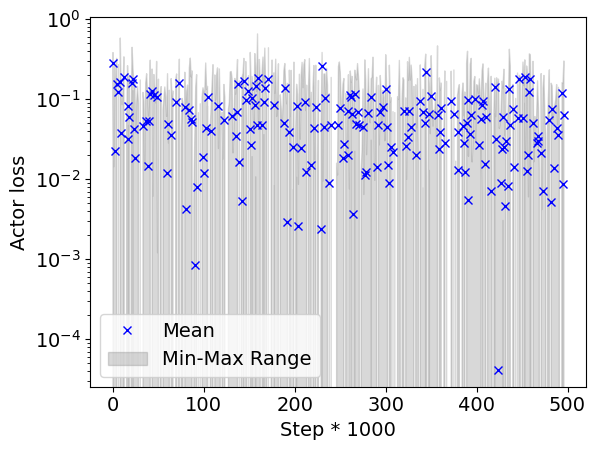

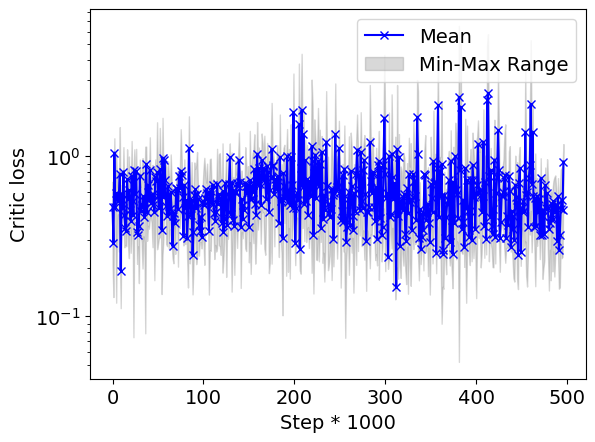

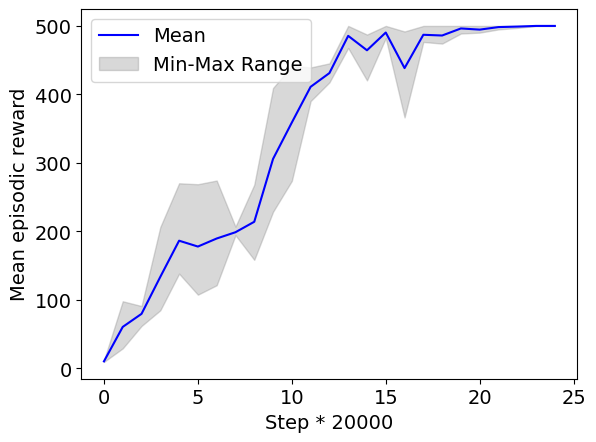

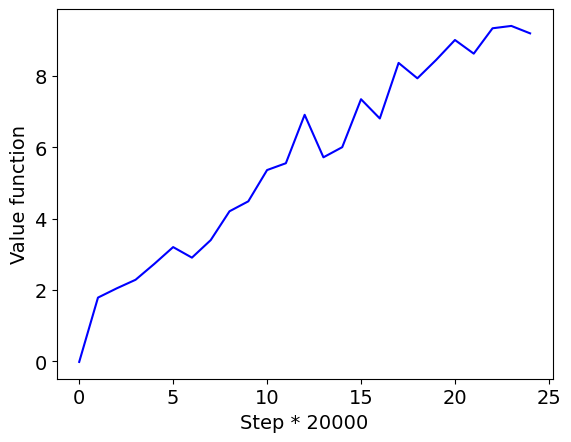

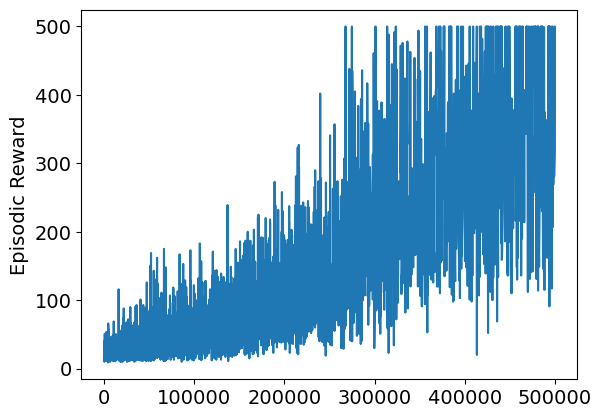

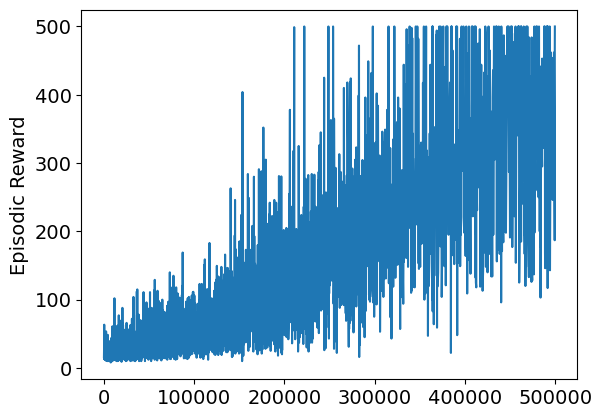

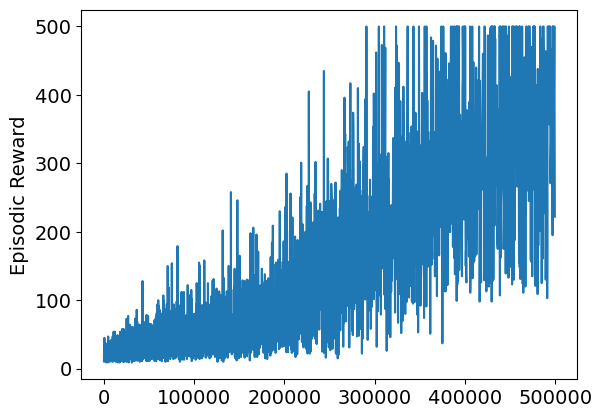

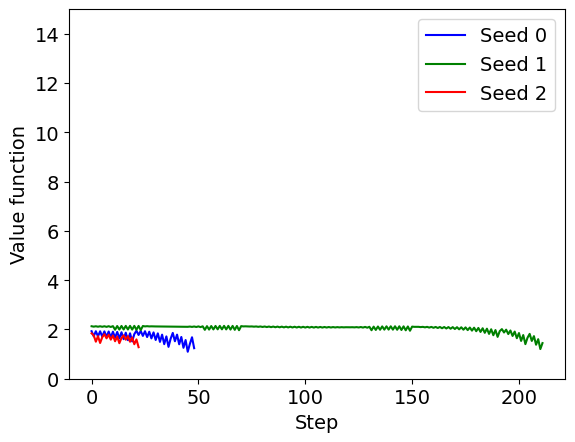

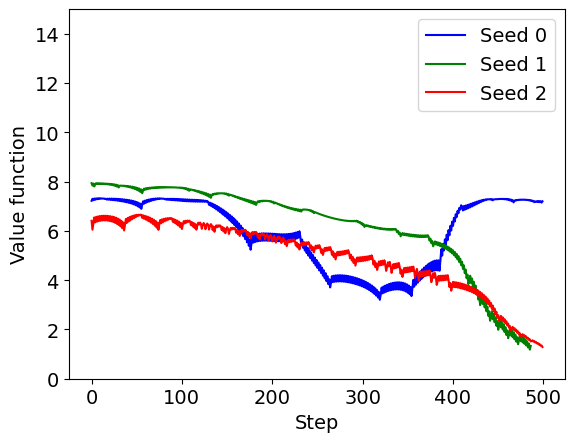

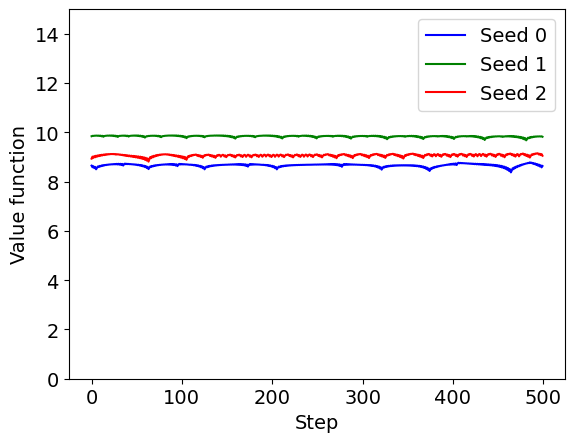

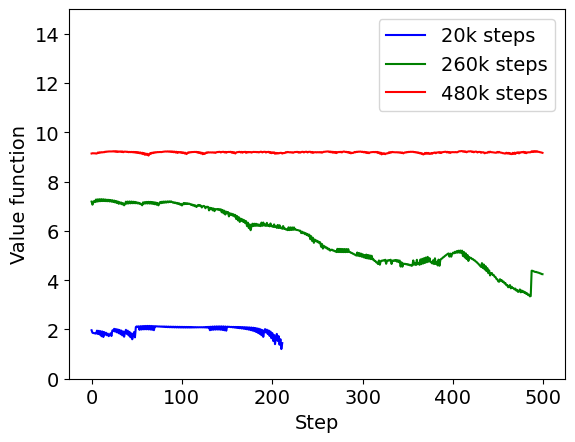

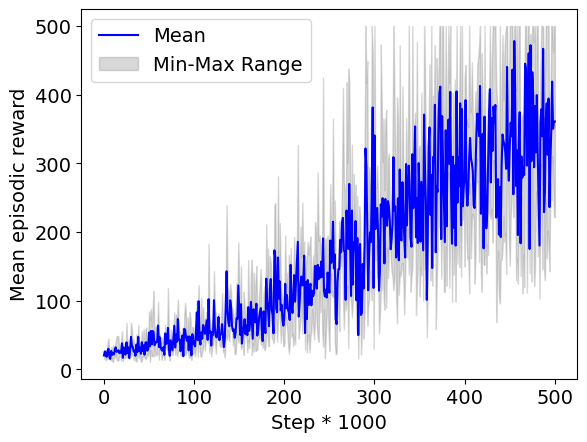

In [98]:
folder_name = 'Results_6env_6step'
plotting(folder_name, seeds)

## Agent 5: 1 env, 1 step, continuous

In [23]:
seeds = [52, 123, 89]
for seed in seeds:
    folder_name = 'Results_1env_1step_cont'
    if not os.path.exists(folder_name): os.makedirs(folder_name)

    filenames = [os.path.join(folder_name, str(seed)+'_1_1k.csv'), os.path.join(folder_name, str(seed)+'_1_20k_rewards.csv'), 
                 os.path.join(folder_name, str(seed)+'_1_20k_V_Values.csv'), os.path.join(folder_name, str(seed)+'_1_Ep_Rewards.csv')]

    train(seed, filenames, n_envs=1, sparse=True, continuous=True)

  0%|          | 29/500000 [00:00<51:48, 160.85it/s]

episodic return of the 20000: 14.1


  4%|▍         | 20037/500000 [01:40<1:00:09, 132.96it/s]

episodic return of the 20000: 113.0


  8%|▊         | 40046/500000 [03:09<1:25:48, 89.34it/s] 

episodic return of the 20000: 324.6


 12%|█▏        | 60038/500000 [04:43<1:08:57, 106.34it/s]

episodic return of the 20000: 214.4


 16%|█▌        | 80010/500000 [06:13<2:05:30, 55.77it/s] 

episodic return of the 20000: 399.5


 20%|██        | 100032/500000 [07:48<4:01:08, 27.64it/s]

episodic return of the 20000: 915.7


 24%|██▍       | 120046/500000 [09:23<4:04:26, 25.91it/s] 

episodic return of the 20000: 1000.0


 28%|██▊       | 140039/500000 [11:04<4:00:23, 24.96it/s] 

episodic return of the 20000: 1000.0


 32%|███▏      | 160026/500000 [12:42<3:35:51, 26.25it/s]

episodic return of the 20000: 1000.0


 36%|███▌      | 180029/500000 [14:20<3:22:18, 26.36it/s]

episodic return of the 20000: 1000.0


 40%|████      | 200043/500000 [16:00<3:22:16, 24.72it/s]

episodic return of the 20000: 1000.0


 44%|████▍     | 220032/500000 [17:39<3:01:07, 25.76it/s]

episodic return of the 20000: 1000.0


 48%|████▊     | 240041/500000 [19:20<3:12:00, 22.56it/s]

episodic return of the 20000: 1000.0


 52%|█████▏    | 260022/500000 [21:28<4:40:50, 14.24it/s]

episodic return of the 20000: 1000.0


 56%|█████▌    | 280037/500000 [23:05<2:00:14, 30.49it/s]

episodic return of the 20000: 1000.0


 60%|██████    | 300005/500000 [24:42<5:44:02,  9.69it/s]

episodic return of the 20000: 1000.0


 64%|██████▍   | 320038/500000 [26:13<1:48:33, 27.63it/s]

episodic return of the 20000: 1000.0


 68%|██████▊   | 340033/500000 [27:40<1:39:30, 26.79it/s]

episodic return of the 20000: 1000.0


 72%|███████▏  | 360040/500000 [29:12<1:26:30, 26.97it/s]

episodic return of the 20000: 1000.0


 76%|███████▌  | 380017/500000 [30:43<1:19:53, 25.03it/s]

episodic return of the 20000: 1000.0


 80%|████████  | 400032/500000 [32:18<58:26, 28.51it/s]  

episodic return of the 20000: 1000.0


 84%|████████▍ | 420037/500000 [33:50<46:09, 28.87it/s]  

episodic return of the 20000: 1000.0


 88%|████████▊ | 440033/500000 [35:22<38:32, 25.93it/s] 

episodic return of the 20000: 1000.0


 92%|█████████▏| 460024/500000 [37:06<23:04, 28.88it/s] 

episodic return of the 20000: 1000.0


 96%|█████████▌| 480036/500000 [39:07<13:28, 24.70it/s] 

episodic return of the 20000: 1000.0


  0%|          | 19/500000 [00:00<1:24:42, 98.38it/s]

episodic return of the 20000: 8.4


  4%|▍         | 20025/500000 [01:46<56:01, 142.80it/s]  

episodic return of the 20000: 69.0


  8%|▊         | 39989/500000 [03:28<31:35, 242.65it/s]  

episodic return of the 20000: 607.4


 12%|█▏        | 60020/500000 [05:18<5:49:19, 20.99it/s] 

episodic return of the 20000: 602.8


 16%|█▌        | 80036/500000 [07:00<1:25:15, 82.09it/s] 

episodic return of the 20000: 255.8


 20%|██        | 100021/500000 [08:46<4:30:55, 24.61it/s]

episodic return of the 20000: 1000.0


 24%|██▍       | 120032/500000 [10:32<3:37:42, 29.09it/s] 

episodic return of the 20000: 1000.0


 28%|██▊       | 140028/500000 [12:23<4:35:22, 21.79it/s] 

episodic return of the 20000: 1000.0


 32%|███▏      | 160035/500000 [14:06<4:19:30, 21.83it/s]

episodic return of the 20000: 1000.0


 36%|███▌      | 180031/500000 [15:53<3:57:31, 22.45it/s]

episodic return of the 20000: 1000.0


 40%|████      | 200030/500000 [17:41<3:49:11, 21.81it/s]

episodic return of the 20000: 1000.0


 44%|████▍     | 220018/500000 [19:28<3:26:28, 22.60it/s]

episodic return of the 20000: 1000.0


 48%|████▊     | 240023/500000 [21:14<4:11:56, 17.20it/s]

episodic return of the 20000: 1000.0


 52%|█████▏    | 260035/500000 [23:01<3:08:33, 21.21it/s]

episodic return of the 20000: 1000.0


 56%|█████▌    | 280031/500000 [24:49<2:36:11, 23.47it/s]

episodic return of the 20000: 1000.0


 60%|██████    | 300024/500000 [26:38<3:18:11, 16.82it/s]

episodic return of the 20000: 1000.0


 64%|██████▍   | 320040/500000 [28:29<2:22:49, 21.00it/s]

episodic return of the 20000: 1000.0


 68%|██████▊   | 340024/500000 [30:15<1:54:30, 23.29it/s]

episodic return of the 20000: 1000.0


 72%|███████▏  | 360040/500000 [32:06<1:41:43, 22.93it/s]

episodic return of the 20000: 1000.0


 76%|███████▌  | 380028/500000 [34:02<1:11:29, 27.97it/s]

episodic return of the 20000: 1000.0


 80%|████████  | 400026/500000 [35:35<56:21, 29.56it/s]  

episodic return of the 20000: 1000.0


 84%|████████▍ | 420041/500000 [37:07<44:55, 29.66it/s]  

episodic return of the 20000: 1000.0


 88%|████████▊ | 440025/500000 [38:39<46:50, 21.34it/s] 

episodic return of the 20000: 1000.0


 92%|█████████▏| 460038/500000 [40:12<22:23, 29.73it/s] 

episodic return of the 20000: 1000.0


 96%|█████████▌| 480031/500000 [41:46<13:13, 25.16it/s] 

episodic return of the 20000: 1000.0


  0%|          | 29/500000 [00:00<54:10, 153.80it/s]

episodic return of the 20000: 13.9


  4%|▍         | 20048/500000 [01:37<51:17, 155.93it/s]  

episodic return of the 20000: 82.0


  8%|▊         | 40030/500000 [03:10<1:01:33, 124.55it/s]

episodic return of the 20000: 142.4


 12%|█▏        | 60033/500000 [04:47<1:09:01, 106.22it/s]

episodic return of the 20000: 207.9


 16%|█▌        | 80025/500000 [06:21<1:07:10, 104.20it/s]

episodic return of the 20000: 182.6


 20%|██        | 100027/500000 [07:57<1:23:47, 79.55it/s]

episodic return of the 20000: 318.9


 24%|██▍       | 119999/500000 [09:33<28:24, 222.93it/s]  

episodic return of the 20000: 490.8


 28%|██▊       | 140039/500000 [11:19<3:54:24, 25.59it/s]

episodic return of the 20000: 1000.0


 32%|███▏      | 160040/500000 [13:01<3:57:27, 23.86it/s]

episodic return of the 20000: 1000.0


 36%|███▌      | 180026/500000 [14:37<2:59:16, 29.75it/s]

episodic return of the 20000: 1000.0


 40%|████      | 200026/500000 [16:03<3:31:24, 23.65it/s]

episodic return of the 20000: 1000.0


 44%|████▍     | 220025/500000 [17:26<2:32:18, 30.64it/s]

episodic return of the 20000: 1000.0


 48%|████▊     | 240029/500000 [18:52<2:18:47, 31.22it/s]

episodic return of the 20000: 1000.0


 52%|█████▏    | 260031/500000 [20:17<1:53:08, 35.35it/s]

episodic return of the 20000: 1000.0


 56%|█████▌    | 280020/500000 [21:41<1:44:36, 35.05it/s]

episodic return of the 20000: 1000.0


 60%|██████    | 300034/500000 [23:06<1:22:44, 40.28it/s]

episodic return of the 20000: 1000.0


 64%|██████▍   | 320039/500000 [24:30<1:30:11, 33.26it/s]

episodic return of the 20000: 1000.0


 68%|██████▊   | 340045/500000 [25:55<1:23:24, 31.96it/s]

episodic return of the 20000: 1000.0


 72%|███████▏  | 360053/500000 [27:18<56:05, 41.59it/s]  

episodic return of the 20000: 1000.0


 76%|███████▌  | 380031/500000 [28:43<59:47, 33.44it/s]  

episodic return of the 20000: 1000.0


 80%|████████  | 400031/500000 [30:08<51:06, 32.60it/s]  

episodic return of the 20000: 1000.0


 84%|████████▍ | 420031/500000 [31:33<40:44, 32.72it/s] 

episodic return of the 20000: 1000.0


 88%|████████▊ | 440044/500000 [32:58<31:19, 31.90it/s] 

episodic return of the 20000: 1000.0


 92%|█████████▏| 460051/500000 [34:21<20:22, 32.67it/s] 

episodic return of the 20000: 1000.0


 96%|█████████▌| 480048/500000 [35:46<09:57, 33.38it/s] 

episodic return of the 20000: 1000.0


100%|██████████| 500000/500000 [37:07<00:00, 224.46it/s]


[-0.076372850375, 1.694300380413223, 2.898082659724242, 3.601878822201835, 2.9197217241186872, 6.298704560322581, 4.903844111000001, 8.442795353, 9.821256169, 9.340213531000002, 9.6175843295, 11.829042827500002, 8.9337266675, 9.2545245695, 10.460458054499998, 10.344353161999999, 10.260821237, 8.312072761, 8.728138052, 11.3326721635, 9.47149612, 8.9463142585, 11.097322451499997, 9.8681630045, 10.138649328999998]


/var/folders/c4/sgxdk2g56dx90j4nw9824_sw0000gn/T/ipykernel_55758/886802808.py:65: RuntimeWarning: Mean of empty slice
  mean_v0 = np.nanmean(v0, axis=0)


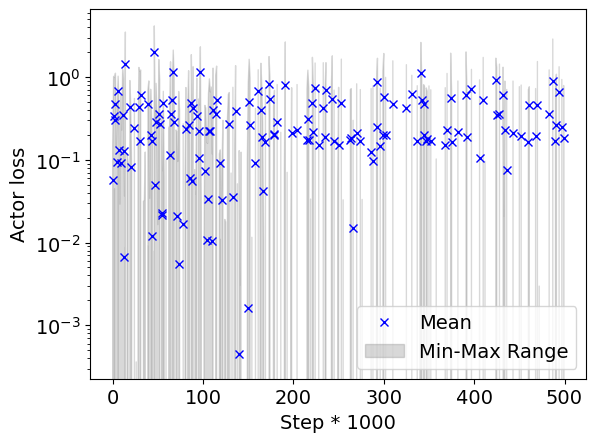

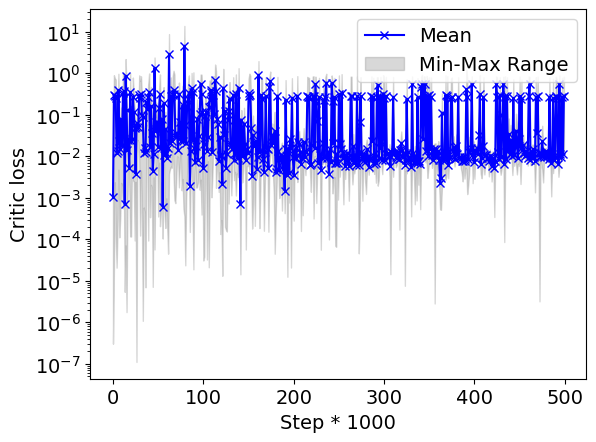

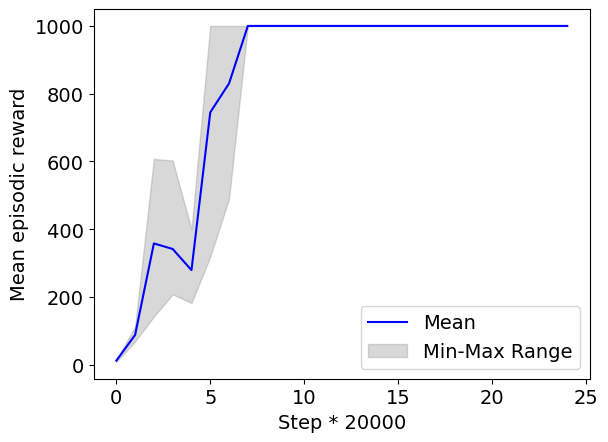

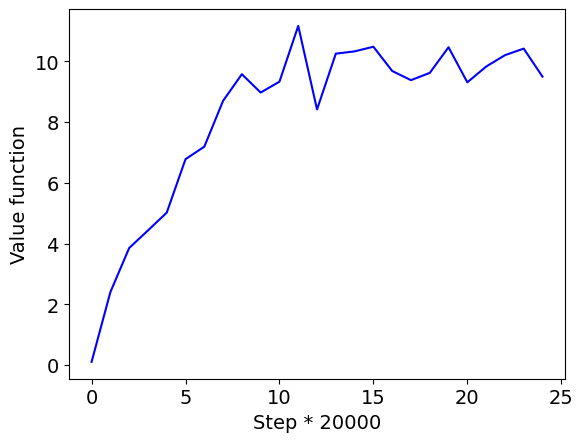

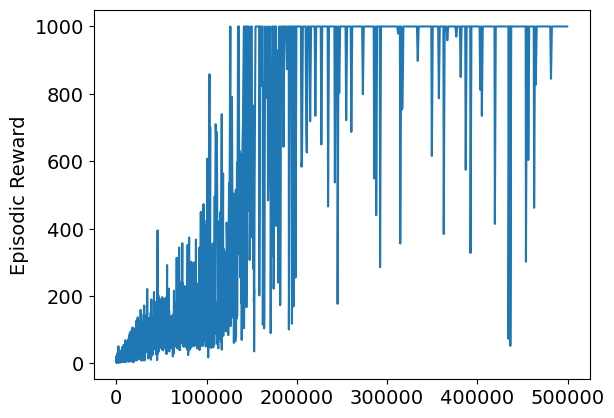

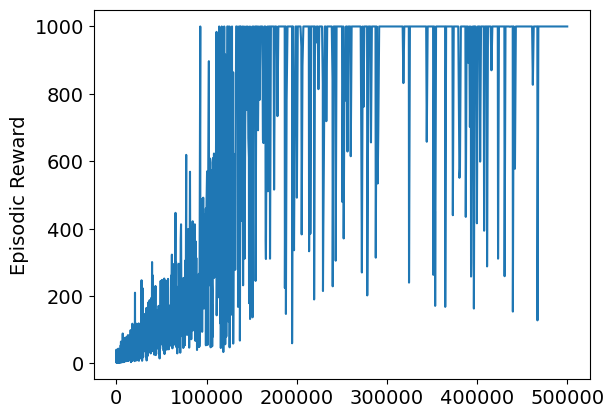

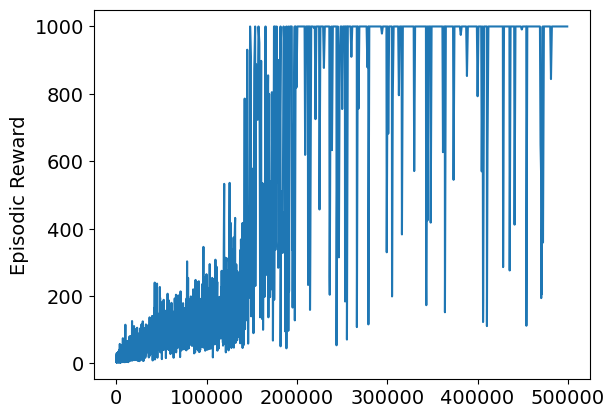

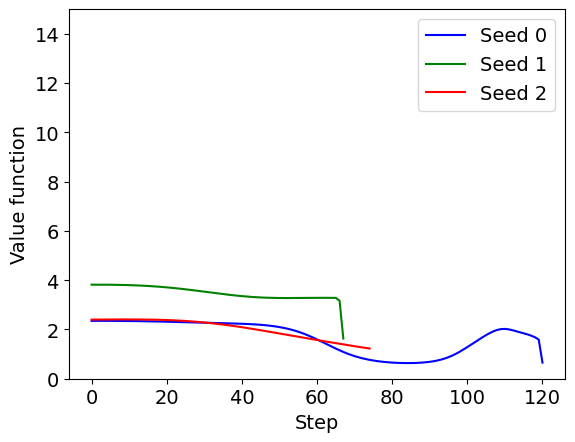

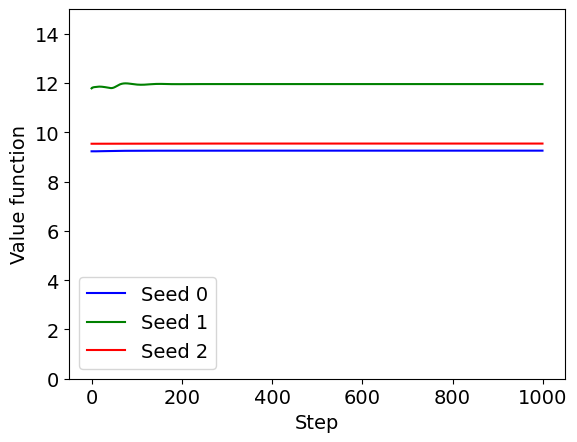

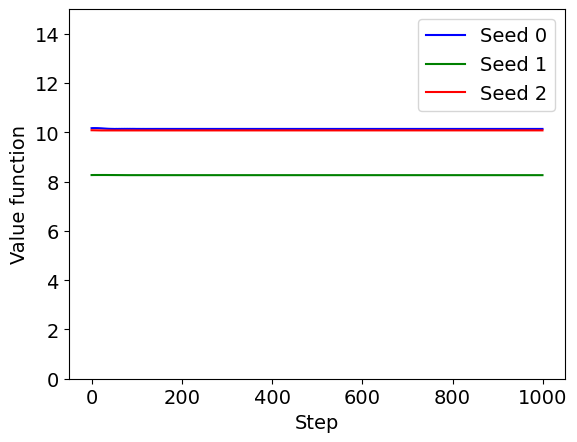

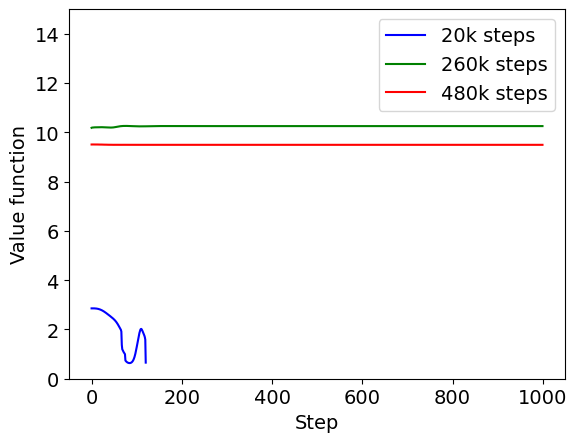

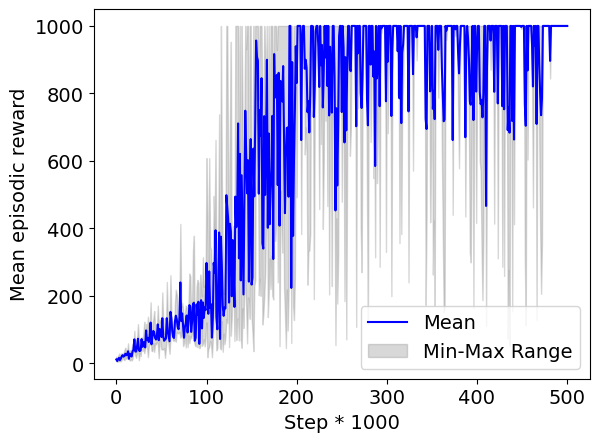

In [101]:
folder_name = 'Results_1env_1step_cont'
plotting(folder_name, seeds)

## Agent 6: 6 envs, 6 steps, continuous

In [11]:
seeds = [52, 123, 89]
for seed in seeds:
    folder_name = 'Results_6env_6step_cont'
    if not os.path.exists(folder_name): os.makedirs(folder_name)

    filenames = [os.path.join(folder_name, str(seed)+'_1_1k.csv'), os.path.join(folder_name, str(seed)+'_1_20k_rewards.csv'), 
                 os.path.join(folder_name, str(seed)+'_1_20k_V_Values.csv'), os.path.join(folder_name, str(seed)+'_1_Ep_Rewards.csv')]

    train_n(seed, filenames, n_envs=6, n_steps=6, sparse=True, continuous=True, lr_actor=3e-4)

  0%|          | 5/13889 [00:00<09:43, 23.80it/s]

episodic return of the 20000: 16.2


  4%|▍         | 564/13889 [00:14<10:50, 20.48it/s]

episodic return of the 20000: 114.3


  8%|▊         | 1119/13889 [00:26<11:04, 19.23it/s]

episodic return of the 20000: 285.7


 12%|█▏        | 1679/13889 [00:41<27:16,  7.46it/s]

episodic return of the 20000: 1000.0


 16%|█▌        | 2231/13889 [00:55<31:05,  6.25it/s]

episodic return of the 20000: 1000.0


 20%|██        | 2790/13889 [01:11<33:22,  5.54it/s]

episodic return of the 20000: 1000.0


 24%|██▍       | 3340/13889 [01:37<1:30:53,  1.93it/s]

episodic return of the 20000: 1000.0


 28%|██▊       | 3897/13889 [01:55<39:37,  4.20it/s]  

episodic return of the 20000: 1000.0


 32%|███▏      | 4456/13889 [02:13<30:00,  5.24it/s]

episodic return of the 20000: 1000.0


 36%|███▌      | 5011/13889 [02:29<29:46,  4.97it/s]

episodic return of the 20000: 1000.0


 40%|████      | 5566/13889 [02:44<29:33,  4.69it/s]

episodic return of the 20000: 1000.0


 44%|████▍     | 6121/13889 [03:02<44:00,  2.94it/s]

episodic return of the 20000: 1000.0


 48%|████▊     | 6680/13889 [03:23<21:25,  5.61it/s]

episodic return of the 20000: 1000.0


 52%|█████▏    | 7236/13889 [03:37<17:38,  6.29it/s]

episodic return of the 20000: 1000.0


 56%|█████▌    | 7791/13889 [03:51<14:40,  6.93it/s]

episodic return of the 20000: 1000.0


 60%|██████    | 8345/13889 [04:05<17:45,  5.20it/s]

episodic return of the 20000: 1000.0


 64%|██████▍   | 8905/13889 [04:19<12:27,  6.67it/s]

episodic return of the 20000: 1000.0


 68%|██████▊   | 9459/13889 [04:33<10:31,  7.01it/s]

episodic return of the 20000: 1000.0


 72%|███████▏  | 10015/13889 [04:50<10:41,  6.04it/s]

episodic return of the 20000: 1000.0


 76%|███████▌  | 10570/13889 [05:05<08:48,  6.27it/s]

episodic return of the 20000: 1000.0


 80%|████████  | 11127/13889 [05:19<06:57,  6.62it/s]

episodic return of the 20000: 1000.0


 84%|████████▍ | 11682/13889 [05:33<05:44,  6.41it/s]

episodic return of the 20000: 1000.0


 88%|████████▊ | 12240/13889 [05:46<03:56,  6.98it/s]

episodic return of the 20000: 1000.0


 92%|█████████▏| 12796/13889 [06:00<02:35,  7.03it/s]

episodic return of the 20000: 1000.0


 96%|█████████▌| 13354/13889 [06:14<01:20,  6.65it/s]

episodic return of the 20000: 1000.0


  0%|          | 7/13889 [00:00<07:34, 30.51it/s]

episodic return of the 20000: 8.5


  4%|▍         | 566/13889 [00:11<05:52, 37.79it/s]

episodic return of the 20000: 79.3


  8%|▊         | 1123/13889 [00:23<06:05, 34.94it/s]

episodic return of the 20000: 114.7


 12%|█▏        | 1674/13889 [00:36<29:08,  6.99it/s]

episodic return of the 20000: 1000.0


 16%|█▌        | 2231/13889 [00:50<29:56,  6.49it/s]

episodic return of the 20000: 1000.0


 20%|██        | 2787/13889 [01:04<26:18,  7.03it/s]

episodic return of the 20000: 1000.0


 24%|██▍       | 3344/13889 [01:17<25:23,  6.92it/s]

episodic return of the 20000: 1000.0


 28%|██▊       | 3899/13889 [01:31<23:18,  7.15it/s]

episodic return of the 20000: 1000.0


 32%|███▏      | 4458/13889 [01:45<27:38,  5.69it/s]

episodic return of the 20000: 1000.0


 36%|███▌      | 5010/13889 [01:59<27:46,  5.33it/s]

episodic return of the 20000: 1000.0


 40%|████      | 5567/13889 [02:13<20:13,  6.86it/s]

episodic return of the 20000: 1000.0


 44%|████▍     | 6122/13889 [02:26<18:19,  7.06it/s]

episodic return of the 20000: 1000.0


 48%|████▊     | 6682/13889 [02:40<17:26,  6.89it/s]

episodic return of the 20000: 1000.0


 52%|█████▏    | 7234/13889 [02:53<21:20,  5.20it/s]

episodic return of the 20000: 1000.0


 56%|█████▌    | 7794/13889 [03:07<14:30,  7.00it/s]

episodic return of the 20000: 1000.0


 60%|██████    | 8347/13889 [03:21<13:31,  6.83it/s]

episodic return of the 20000: 1000.0


 64%|██████▍   | 8906/13889 [03:35<11:27,  7.25it/s]

episodic return of the 20000: 1000.0


 68%|██████▊   | 9458/13889 [03:48<14:02,  5.26it/s]

episodic return of the 20000: 1000.0


 72%|███████▏  | 10017/13889 [04:02<09:20,  6.91it/s]

episodic return of the 20000: 1000.0


 76%|███████▌  | 10571/13889 [04:16<08:09,  6.78it/s]

episodic return of the 20000: 1000.0


 80%|████████  | 11128/13889 [04:30<06:36,  6.97it/s]

episodic return of the 20000: 1000.0


 84%|████████▍ | 11683/13889 [04:43<05:34,  6.60it/s]

episodic return of the 20000: 1000.0


 88%|████████▊ | 12238/13889 [04:57<05:07,  5.37it/s]

episodic return of the 20000: 1000.0


 92%|█████████▏| 12796/13889 [05:11<02:33,  7.12it/s]

episodic return of the 20000: 1000.0


 96%|█████████▌| 13353/13889 [05:24<01:15,  7.09it/s]

episodic return of the 20000: 1000.0


  0%|          | 6/13889 [00:00<07:55, 29.22it/s]

episodic return of the 20000: 13.1


  4%|▍         | 561/13889 [00:11<10:25, 21.30it/s]

episodic return of the 20000: 218.7


  8%|▊         | 1123/13889 [00:24<09:46, 21.78it/s]

episodic return of the 20000: 297.9


 12%|█▏        | 1676/13889 [00:39<39:06,  5.20it/s]  

episodic return of the 20000: 1000.0


 16%|█▌        | 2233/13889 [00:52<28:19,  6.86it/s]

episodic return of the 20000: 1000.0


 20%|██        | 2786/13889 [01:06<28:30,  6.49it/s]

episodic return of the 20000: 1000.0


 24%|██▍       | 3342/13889 [01:20<34:00,  5.17it/s]

episodic return of the 20000: 1000.0


 28%|██▊       | 3896/13889 [01:34<31:12,  5.34it/s]

episodic return of the 20000: 1000.0


 32%|███▏      | 4458/13889 [01:48<23:03,  6.81it/s]

episodic return of the 20000: 1000.0


 36%|███▌      | 5014/13889 [02:01<20:31,  7.21it/s]

episodic return of the 20000: 1000.0


 40%|████      | 5566/13889 [02:15<28:15,  4.91it/s]

episodic return of the 20000: 1000.0


 44%|████▍     | 6124/13889 [02:29<18:14,  7.09it/s]

episodic return of the 20000: 1000.0


 48%|████▊     | 6682/13889 [02:43<17:07,  7.02it/s]

episodic return of the 20000: 1000.0


 52%|█████▏    | 7234/13889 [02:56<20:51,  5.32it/s]

episodic return of the 20000: 1000.0


 56%|█████▌    | 7792/13889 [03:10<15:43,  6.46it/s]

episodic return of the 20000: 1000.0


 60%|██████    | 8347/13889 [03:24<13:44,  6.73it/s]

episodic return of the 20000: 1000.0


 64%|██████▍   | 8901/13889 [03:38<15:45,  5.28it/s]

episodic return of the 20000: 1000.0


 68%|██████▊   | 9464/13889 [03:52<10:32,  6.99it/s]

episodic return of the 20000: 1000.0


 72%|███████▏  | 10014/13889 [04:05<09:59,  6.46it/s]

episodic return of the 20000: 1000.0


 76%|███████▌  | 10573/13889 [04:19<08:10,  6.77it/s]

episodic return of the 20000: 1000.0


 80%|████████  | 11129/13889 [04:33<06:19,  7.27it/s]

episodic return of the 20000: 1000.0


 84%|████████▍ | 11687/13889 [04:47<05:00,  7.32it/s]

episodic return of the 20000: 1000.0


 88%|████████▊ | 12238/13889 [05:00<04:10,  6.59it/s]

episodic return of the 20000: 1000.0


 92%|█████████▏| 12798/13889 [05:14<02:42,  6.73it/s]

episodic return of the 20000: 1000.0


 96%|█████████▌| 13351/13889 [05:28<01:18,  6.81it/s]

episodic return of the 20000: 1000.0


100%|██████████| 13889/13889 [05:38<00:00, 41.06it/s]


[-0.07503495106250001, 3.614976305454545, 5.566057072118959, 7.167264138300001, 9.985517493, 9.961086795, 10.2908013215, 10.5052990575, 10.179853771000001, 9.772272281000001, 9.5481204905, 10.202970176, 9.619617115999999, 10.0723901815, 10.811534708000003, 9.7114663955, 10.410324126999999, 10.6201699175, 10.2565917195, 11.454369441000003, 10.102495616, 9.9736211885, 10.184501175500001, 10.384118239, 10.486168655499998]


/var/folders/c4/sgxdk2g56dx90j4nw9824_sw0000gn/T/ipykernel_55758/886802808.py:65: RuntimeWarning: Mean of empty slice
  mean_v0 = np.nanmean(v0, axis=0)


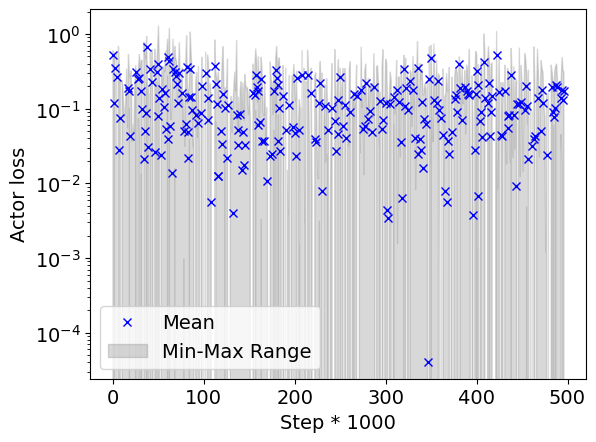

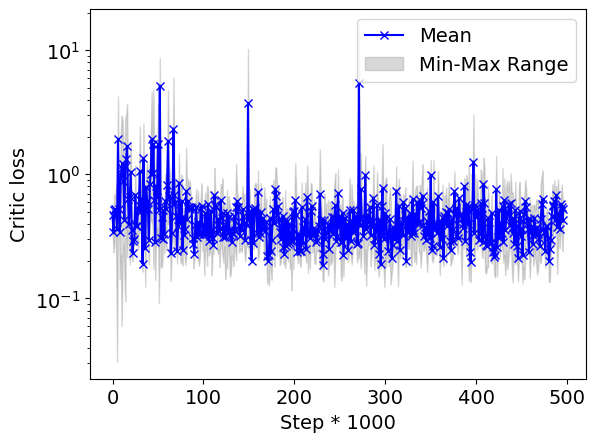

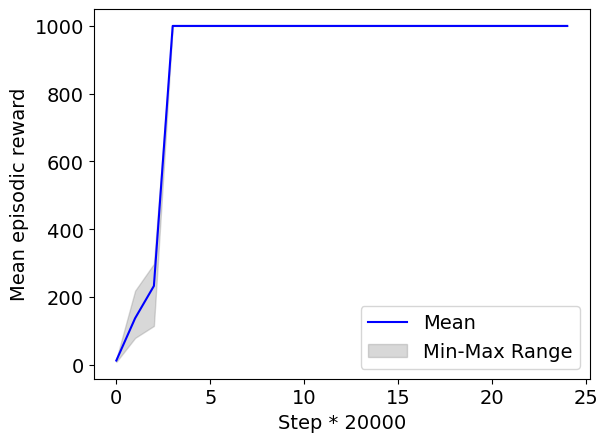

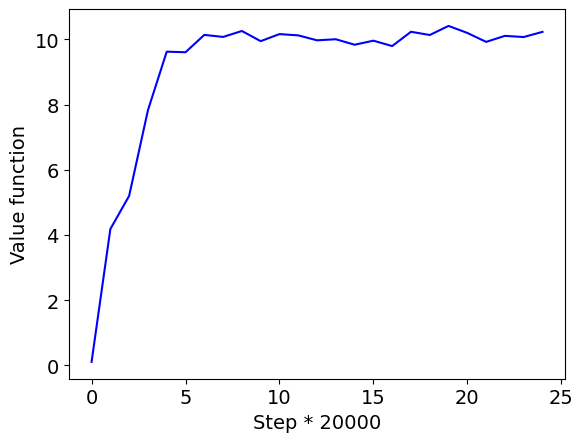

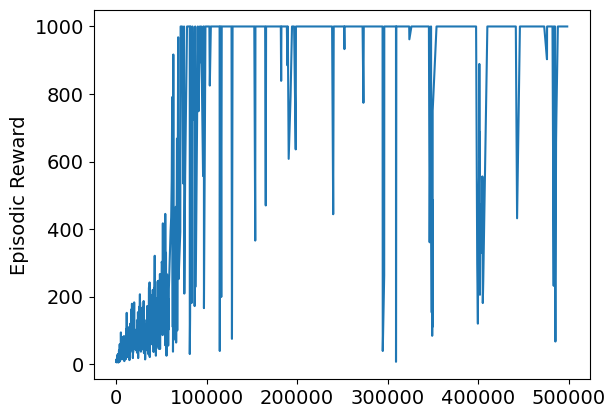

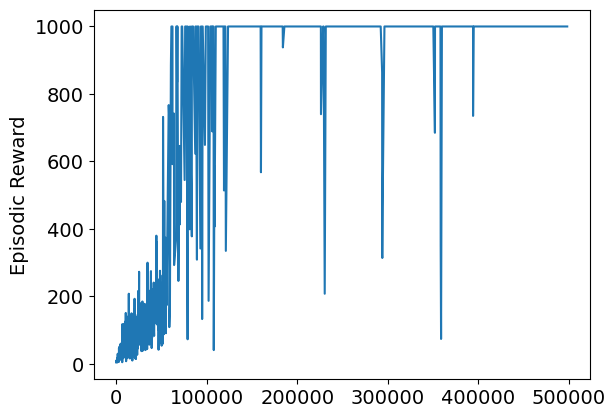

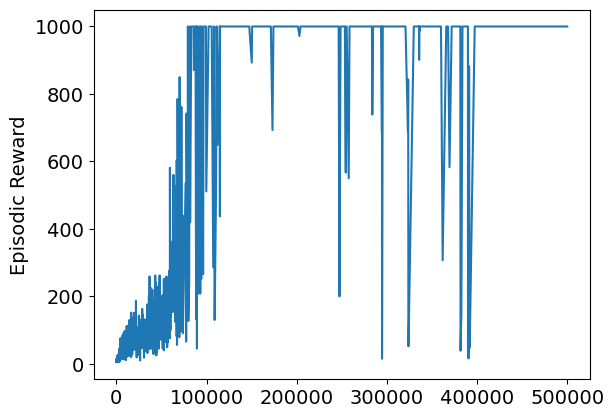

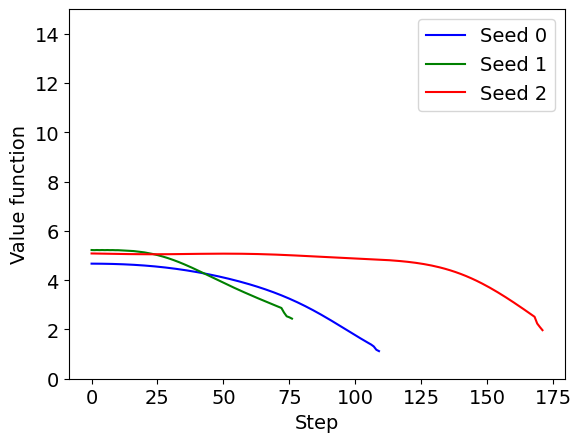

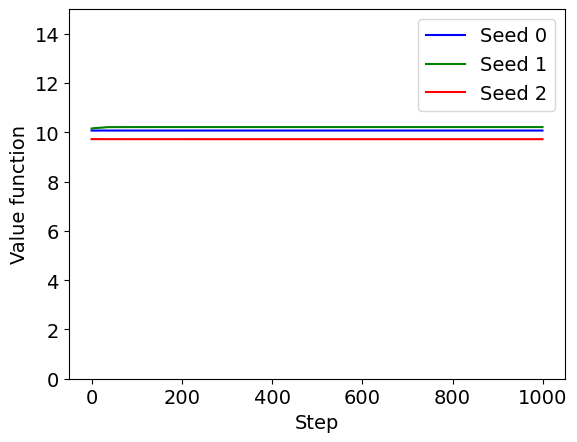

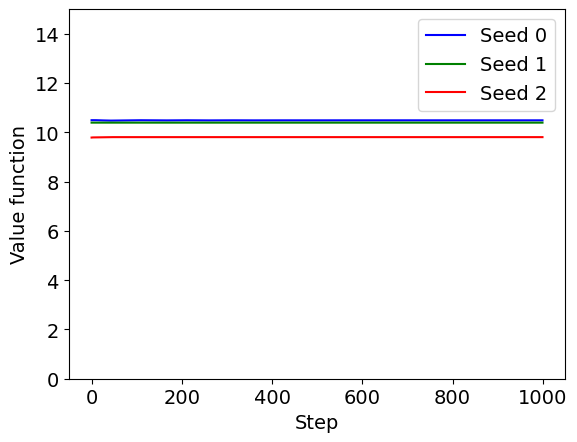

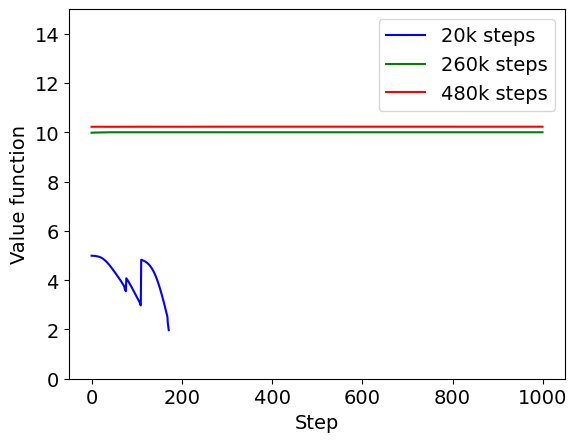

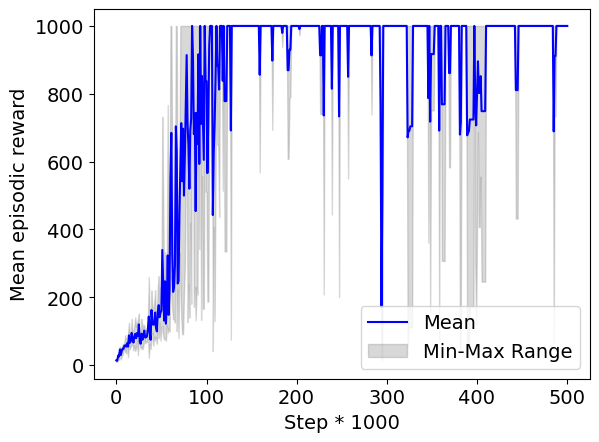

In [102]:
folder_name = 'Results_6env_6step_cont'
plotting(folder_name, seeds)